# fast estimation of particle properties
Tim Tyree<br>
9.29.2021<br>
`conda activate pyenv_ub`

__GOALS__:
- DONE: compute dRdt versus 1/R for unconstrained random samples from smoothed and validated trajectories
- TODO: compute a from a bootstrap of 1/R versus a for one input_fn
- TODO: compute a from a bootstrap of 1/R versus a for one input_fn_lst
- TODO: compute a from a bootstrap of 1/R versus a for each input_fn_lst
- TODO: repeat for measuring ensemble MSD to give the diffusion coefficient, D
- TODO(later?): efficiently generate an _inline_ rendering of dRdt versus 1/R and MSD versus tau using dashly.  try the solution suggested on my stackoverflow post
- TODO: generate a .bluf for each input_fn_lst to document the particle property measurements
- TODO: show qualitative insenstivity to choice in navg1 and navg2

__TODO(later):__ bug mike to make certain that for the 99.95% accurate decoder, that the i^th neuron for the Match trials is the same as the i^th neuron for the Mismatch trials for all i neuron-units considered.

howdo hierarchical multi-indexing: https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html#hierarchical-indexing-multiindex

In [1]:
from lib.my_initialization import *
from lib import *
# from lib.measure.unwrap_and_smooth_cu import *
# from lib.rapids_func import *
# .routines.unwrap_and_smooth_trajectories_cu import *

import itertools
import dask_cudf
from lib.rapids_func import *
get_DT_cu

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

import cupy as cp, cudf, numba.cuda as cuda
import rmm
# Switch to RMM allocator
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

Automatic calling is: Smart


In [2]:
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [3]:
# print(f"With a diffusion coefficient of D=0.7 cm^2/s, we observed an apparent bias smaller than ??% for control trials.")

__Schema__
- a, D
    - tavg1, tavg2, slope_5, slope_25, slope_40, 

- input: folder of trajectories
- output: list of tavg1, tavg2, slope_5, slope_25, slope_40, Delta_slope_5, Delta_slope_25, Delta_slope_40

- How far do particles need to start in order to collide within 100 ms?

# (optional, skipme) postprocess an individual token trajectory file
- Nota Bene: batch computation of a list of folders of data runs is already automated and optimized in 'fast postprocessing a list of trajectory folders.ipynb'

In [4]:
# search_for_file()
# np.sqrt(2),1/np.sqrt(2)

In [5]:
tavg1=4#8#4 #moving average window, in ms

# tavg2=12#24 #ms #savgol_filter time window performed on R 
tavg2=24# #ms #savgol_filter time window performed on R  #12 ms was no longer smooth
# tavg2=10.# #ms #savgol_filter time window performed on R  #12 ms was no longer smooth

In [6]:
#particle model token trajectories
# # #neighbors=0
# input_fn_lst = [
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_0_L_10_kappa_0_varkappa_0/Log/pbc_particle_log1_log.csv',
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_0_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv',
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_0_varkappa_0/Log/pbc_particle_log5_log.csv',
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_0/Log/pbc_particle_log5_log.csv',
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log5_log.csv'
# ]


# # #neighbors=1
# input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0_L_10_kappa_1500_varkappa_5_N_2/Log/pbc_particle_log2_log.csv' 
# # # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv'  
# # # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv'


#two particle control with diffusion
input_fn_lst = [
'/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0.7_L_10_kappa_1500_varkappa_5_N_2/Log/pbc_particle_log1_log.csv'
]

#choose a file for initialization/testing 
input_fn=input_fn_lst[-1]
print(input_fn)
#choose parameters
pid_col='pid_explicit'
width=10
ds=10. #cm for the whole domain
tmin=0.
c='C3'

/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0.7_L_10_kappa_1500_varkappa_5_N_2/Log/pbc_particle_log1_log.csv


In [7]:
# input_fn=search_for_file()
# c='C0'
# # # # #token FK at DT=0.4
# # input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"

c='C1'
# #tokenLR at DT=0.5
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.31_traj_sr_600_mem_0.csv"
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv"

pid_col='particle'
width=200
ds=5. #cm for the whole domain
tmin=100.


#test routine on one file
testing=False
if testing:
    t_col='t'
    df=pd.read_csv(input_fn)
    DT=np.around(get_DT(df, t_col=t_col, pid_col=pid_col),5);print(f"DT={DT}")
    # ds=5 #cm
    # DS=ds/width
#     width=200
    height=width
    use_drop_shorter_than=True
    drop_shorter_than=50 #ms
#     tmin=100.#ms
#     pid_col='particle'
    
    printing=False
    navg1=int(tavg1/DT)
    save_dir=return_moving_average_of_pbc_trajectories_and_save(
            input_fn, tavg1, pid_col, t_col, DT, width, height,
            use_drop_shorter_than, drop_shorter_than, tmin, printing)
    print(save_dir)

    df=load_smoothed_trajectories(save_dir,pid_col,t_col)
    df.head()

    # df.head()

    # input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_tavg_4/ic002.11_traj_sr_600_mem_0_smoothed.csv"
    input_fn=save_dir
    dfr_dir=routine_compute_radial_velocities_pbc_cu(input_fn,
                                                 tavg2,
                                                 width,  #for handling periodic boundary conditions (pbc)
                                                 height, #for handling periodic boundary conditions (pbc)
                                                 ds,     #domain size in cm.  set to width to have nulled effect
                                                 max_dtmax_thresh = 0,      #ms
                                                 max_Rfinal_thresh = 0.2,   #cm
                                                 min_duration_thresh = 40,  #ms
                                                 round_t_to_n_digits=7,
                                                 trial_col='event_id_int',
                                                 pid_col=pid_col,
                                                 t_col='t',
                                                 use_tavg2=True,
                                                 save_df_pairs=True,
                                                 printing=True,
                                                 testing=True)#,**kwargs)
    

    df=pd.read_csv(dfr_dir)
    df.head()

In [8]:
# dfr_dir
# os.path.exists(dfr_dir)

In [9]:
annihilation_folder_fk='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005'#/smoothed_trajectory_pairs_tavg1_4_tavg2_24.4'
len(os.listdir(annihilation_folder_fk))

62

In [10]:
# np.unique(df['event_id_int'].values)

__Expected output is along the lines of:__<br> DT=0.25 ms
savistzky-golay time window in use: 24.25 ms
using 1 cores to identify pairs of particles that coexist over 1 independent trials...
selected 1 particle pairs as annihilating out of 1 possible particle pairs
radial velocities of annihilation events were successfully saved to csv

# compute and plot of mean squared range for a given tavg1, tavg2 from raw trajectories from the full model

In [11]:
##########################
# Perform Averaging
##########################
tavg1=0
tavg2=14#todo 0
#one token trajectory file for the fenton karma model and the luo-rudy model
input_fn_lst=[
# c='C0'
# # # # #token FK at DT=0.4
"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv",
# c='C1'
# #tokenLR at DT=0.5
"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv",   
]

kwargs_particle=dict(
        max_dtmax_thresh=0,  #ms
        max_Rfinal_thresh=0.2,  #cm
        min_duration_thresh=15,  #ms
        npartitions=10,#None,
        width=10,
        height=10,
        ds=10,
        use_drop_shorter_than=False,
        drop_shorter_than=0,  #ms
        tmin=0.,  #ms
        pid_col='pid_explicit',
        t_col='t',
        npartitions2=1,
        printing=True)

kwargs_full=dict(
        max_dtmax_thresh = 0,      #ms
        max_Rfinal_thresh = 0.2,   #cm
        min_duration_thresh = 40,  #ms
        npartitions=None,
        width=200,
        height=200,
        ds=5,
        use_drop_shorter_than=True,
        drop_shorter_than=40, #ms
        tmin=100., #ms
        pid_col='particle',
        t_col='t',
        npartitions2=1,
        printing=True)

save_dir_lst2_lst=[]
for input_fn in input_fn_lst:
    df = pd.read_csv(input_fn)
    DT = np.around(get_DT(df, pid_col=pid_col), 7)
    print(f"DT={DT} ms")
    retval = routine_postprocess_trajectory_folder(
        input_fn,
        DT,
        tavg1=tavg1,
        tavg2=tavg2,
        **kwargs_full)
    save_dir_lst, save_dir_lst2 = retval
    save_dir_lst2_lst.append(save_dir_lst2)

saving=True
if saving:
    #save data to cache
    #FK at 0.4ms
    save_folder='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results'
    data_dir_fk=f'{save_folder}/annihilation_data_fk_tavg1_{tavg1:.1f}_tavg2_{tavg2:.2f}.csv'
    df_fk=dask_cudf.read_csv(save_dir_lst2_lst[0]).compute()
    df_fk.to_csv(data_dir_fk,index=False)
    #LR at 0.5ms
    data_dir_lr=f'{save_folder}/annihilation_data_lr_tavg1_{tavg1:.1f}_tavg2_{tavg2:.2f}.csv'
    df_lr=dask_cudf.read_csv(save_dir_lst2_lst[1]).compute()
    df_lr.to_csv(data_dir_lr,index=False)
    print(f"saved to\ndata_dir_fk='{data_dir_fk}'\ndata_dir_lr='{data_dir_lr}'")

DT=0.4 ms
running return_moving_average_of_pbc_trajectories_and_save on 648 files...
the run time was 1.30 minutes.
the number of successfully smoothed trajectory files was 324
the run time was 2.78 minutes.
the number of trajectory files processed to annihilation files was 323
DT=0.5 ms
running return_moving_average_of_pbc_trajectories_and_save on 159 files...
the run time was 2.02 minutes.
the number of successfully smoothed trajectory files was 157
the run time was 3.55 minutes.
the number of trajectory files processed to annihilation files was 140
saved to
data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_0.0_tavg2_14.00.csv'
data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_0.0_tavg2_14.00.csv'


In [12]:
#beep
beep(10)



0

msr_dir_fk=/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_0.0_tavg2_14.00_msr.csv
msr_dir_lr=/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_0.0_tavg2_14.00_msr.csv


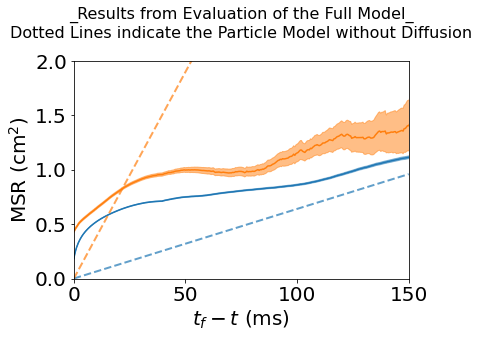

R_col=R_nosavgol, tavg1=0 ms, tavg2=14 ms


In [13]:
##########################
# Compute MSR
##########################
R_col='R_nosavgol'
# R_col='R'
#load cached data
#FK at 0.4ms
#LR at 0.5ms
# data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_4.0_tavg2_14.00.csv'
# data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_4.0_tavg2_14.00.csv'
data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_0.0_tavg2_14.00.csv'
data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_0.0_tavg2_14.00.csv'
df_fk=pd.read_csv(data_dir_fk)
df_lr=pd.read_csv(data_dir_lr)

# # print(len(save_dir_lst2))
# # print(save_dir_lst2[0])
# print(df_fk.head(2))
# print(df_lr.head(2))

#TODO: dev alignment routine to shift R_col and tdeath s.t. at time t=0, R=0, via linear interpolation of the at least the first two data points

minnumobs=8
#fenton karma msr dataframe
groups=df_fk.groupby('tdeath')
tdeath_lst=[]
avg_lst=[]
stderror_lst=[]
sqavg_lst=[]
sqstderror_lst=[]
count_lst=[]
for n,g in groups:
    ##DONE: print each tdeath value 
    # print(n)
    gr=g[R_col]
    counts=gr.count()#.values
    if (minnumobs<=counts).all():
        #TODO: compute average and stderror of each group of tdeath
        avg=gr.mean()#.values
        stddev=gr.std()#.values
        stderror=stddev/np.sqrt(counts)
        
        #TODO: compute squared average
        sq=gr**2
        sqavg=sq.mean()#.values
        sqstddev=sq.std()#.values
        sqstderror=sqstddev/np.sqrt(counts)
        #record
        tdeath_lst.append(n)        
        avg_lst.append(avg)
        stderror_lst.append(stderror)
        sqavg_lst.append(sqavg)
        sqstderror_lst.append(sqstderror)
        count_lst.append(counts)
        
#collect each field into a pandas.DataFrame
df_msr_fk=pd.DataFrame({
    'tdeath':tdeath_lst,
    'avg':avg_lst,
    'stderror':stderror_lst,  
    'sqavg':sqavg_lst,
    'sqstderror':sqstderror_lst,  
    'counts':count_lst
})    
#
# #TODO: repeat with lr
groups=df_lr.groupby('tdeath')
tdeath_lst=[]
avg_lst=[]
stderror_lst=[]
sqavg_lst=[]
sqstderror_lst=[]
count_lst=[]
for n,g in groups:
    ##DONE: print each tdeath value 
    # print(n)
    gr=g[R_col]
    counts=gr.count()#.values
    if (minnumobs<=counts).all():
        #TODO: compute average and stderror of each group of tdeath
        avg=gr.mean()#.values
        stddev=gr.std()#.values
        stderror=stddev/np.sqrt(counts)
        
        #TODO: compute squared average
        sq=gr**2
        sqavg=sq.mean()#.values
        sqstddev=sq.std()#.values
        sqstderror=sqstddev/np.sqrt(counts)
        #record
        tdeath_lst.append(n)        
        avg_lst.append(avg)
        stderror_lst.append(stderror)
        sqavg_lst.append(sqavg)
        sqstderror_lst.append(sqstderror)
        count_lst.append(counts)
        
#collect each field into a pandas.DataFrame
df_msr_lr=pd.DataFrame({
    'tdeath':tdeath_lst,
    'avg':avg_lst,
    'stderror':stderror_lst,  
    'sqavg':sqavg_lst,
    'sqstderror':sqstderror_lst,  
    'counts':count_lst
})    
# print(df_msr_lr.head())

saving=True
if saving:
    #(optional): save as csv
    msr_dir_fk=data_dir_fk.replace('.csv','_msr.csv')
    df_msr_fk.to_csv(msr_dir_fk,index=False)
    print(f'msr_dir_fk={msr_dir_fk}')
    msr_dir_lr=data_dir_lr.replace('.csv','_msr.csv')
    df_msr_lr.to_csv(msr_dir_lr,index=False)
    print(f'msr_dir_lr={msr_dir_lr}')

##########################
# Visualize MSR
##########################
# #extract values to visualize
# msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_4.0_tavg2_14.00_msr.csv'
# msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_4.0_tavg2_14.00_msr.csv'
# #DONT/TODO: worry about the slope for now?
#TODO: verify that the x axis is in units of seconds and not milliseconds
df_msr_fk.sort_values(by='tdeath',inplace=True)
df_msr_lr.sort_values(by='tdeath',inplace=True)
x_values_fk=df_msr_fk['tdeath'].values
y_values_fk=df_msr_fk['sqavg'].values**.5
yerr_values_fk=df_msr_fk['sqstderror'].values
x_values_lr=df_msr_lr['tdeath'].values
y_values_lr=df_msr_lr['sqavg'].values**.5
yerr_values_lr=df_msr_lr['sqstderror'].values
# print(f'R_col={R_col}, tavg1={tavg1} ms, tavg2={tavg2} ms')

#plot overview
# #plot ^those resulting df_msr versus tdeath
# plt.plot(x_values_fk/1e3,y_values_fk,c='C0')
# plt.fill_between(x_values_fk/1e3,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,color='C0',alpha=0.5)
# plt.plot(x_values_lr/1e3,y_values_lr,c='C1')
# plt.fill_between(x_values_lr/1e3,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,color='C1',alpha=0.5)
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (s)',ylabel=r'MSR (cm$^2$)',use_loglog=False)
# # plt.xlim([0,.05])
# # plt.xlim([0,1])
# # plt.ylim([0,2])
# plt.show()
# print(f'R_col={R_col}, tavg1={tavg1} ms, tavg2={tavg2} ms')

#plot loglog
# #plot ^those resulting df_msr versus tdeath
# plt.plot(x_values_fk,y_values_fk,c='C0')
# plt.fill_between(x_values_fk,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,color='C0',alpha=0.5)
# plt.plot(x_values_lr,y_values_lr,c='C1')
# plt.fill_between(x_values_lr,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,color='C1',alpha=0.5)
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)',use_loglog=True)
# # plt.xlim([0,.05])
# # plt.xlim([0,1])
# plt.ylim([0.1,3])
# plt.show()
# print(f'R_col={R_col}, tavg1={tavg1} ms, tavg2={tavg2} ms')

#plot zoomed to 40ms
# #plot ^those resulting df_msr versus tdeath
# plt.plot(x_values_fk,y_values_fk,c='C0')
# plt.fill_between(x_values_fk,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,color='C0',alpha=0.5)
# plt.plot(x_values_lr,y_values_lr,c='C1')
# plt.fill_between(x_values_lr,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,color='C1',alpha=0.5)
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)',use_loglog=False)
# plt.xlim([0.,45])
# # plt.xlim([0,1])
# plt.ylim([0,1.2])
# plt.show()
# print(f'R_col={R_col}, tavg1={tavg1} ms, tavg2={tavg2} ms')

xmin=0#.1
xmax=150
#plot ^those resulting df_msr versus tdeath
plt.plot(x_values_fk,y_values_fk,c='C0')
plt.fill_between(x_values_fk,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,color='C0',alpha=0.5)
plt.plot(x_values_lr,y_values_lr,c='C1')
plt.fill_between(x_values_lr,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,color='C1',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)',use_loglog=False)
plt.xlim([xmin,xmax])
xv=np.linspace(xmin,xmax,100)
plt.plot(xv,xv*4*1.6*1e-3,'C0--',lw=2,alpha=0.7)
plt.plot(xv,xv*4*9.5*1e-3,'C1--',lw=2,alpha=0.7)
# plt.xlim([0,1])
plt.ylim([0,2])
# plt.ylim([0.5,2])
fontsize=16
# plt.legend(fontsize=fontsize-4,loc='upper right')
plt.title('_Results from Evaluation of the Full Model_\nDotted Lines indicate the Particle Model without Diffusion\n',fontsize=fontsize)
plt.show()
print(f'R_col={R_col}, tavg1={tavg1} ms, tavg2={tavg2} ms')

In [230]:
#estimate the attraction coefficient for the FK model
tmax=50
tdeath_values=x_values_fk.copy()
MSR_values=y_values_fk.copy()
boo=tdeath_values<tmax#sec
dict_a=compute_95CI_ols(tdeath_values[boo]*1e-3,MSR_values[boo])
a_apparent=dict_a['m']/4
Delta_a_apparent=dict_a['Delta_m']/4
Rsq=dict_a['Rsquared']
a_hat_fk=a_apparent
Delta_a_hat_fk=Delta_a_apparent
print(f"for FK, a_hat={a_apparent:.4f}+/-{Delta_a_apparent:.4f} cm^2/s, tmax={tmax}ms, R^2={Rsq:.4f}")
#estimate the attraction coefficient for the LR model
tmax=40
tdeath_values=x_values_fk.copy()
MSR_values=y_values_fk.copy()
boo=tdeath_values<tmax#sec
dict_a=compute_95CI_ols(tdeath_values[boo]*1e-3,MSR_values[boo])
a_apparent=dict_a['m']/4
Delta_a_apparent=dict_a['Delta_m']/4
Rsq=dict_a['Rsquared']
a_hat_lr=a_apparent
Delta_a_hat_lr=Delta_a_apparent
print(f"for LR, a_hat={a_apparent:.4f}+/-{Delta_a_apparent:.4f} cm^2/s, tmax={tmax}ms, R^2={Rsq:.4f}")
print(f'R_col={R_col}, tavg1={tavg1} ms, tavg2={tavg2} ms')
print(f'TODO: align all annihilation events s.t. MSR(0)=0 (i) linear extrapolation or (ii) using OLS')
print(f"TODO: visualize a_hat_fk, a_hat_lr with and without smoothing via (i) moving avg. and (ii) savgol")

for FK, a_hat=1.6689+/-0.1511 cm^2/s, tmax=50ms, R^2=0.7920
for LR, a_hat=2.1647+/-0.1904 cm^2/s, tmax=40ms, R^2=0.8352
R_col=R_nosavgol, tavg1=0 ms, tavg2=14 ms
TODO: align all annihilation events s.t. MSR(0)=0 (i) linear extrapolation or (ii) using OLS
TODO: visualize a_hat_fk, a_hat_lr with and without smoothing via (i) moving avg. and (ii) savgol


In [ ]:
# # num_split=3#between FK and LR
# # Dmax=.7#parameter for alpha channel
# label_fk=r'a$_{FK,\;emergent}=1.6$ cm$^2$/s'#'Fenton-Karma\n(Emergent Attraction)'
# label_lr=r'a$_{LR,\;emergent}=9.5$ cm$^2$/s'#'Luo-Rudy\n(Emergent Attraction)'
# # mean squared ranges resulting from from the particle model
# #TODO(prioritize this for a minimalist MVP): measure the attraction coefficient of each of these values
# tmax=5e-3#sec
# ahat_lst_FK=[]
# ahat_lst_LR=[]
# Delta_ahat_lst_FK=[]
# #plot FK for variable D
# D_lst_FK=[]
# print(f"\ncomputing slope/4 for t<tmax={tmax*1e3:.1f} ms...")
# print(f"starting Fenton-Karma model...")
# for n,input_fn in enumerate(input_fn_lst[:num_split]):
#     data=np.load(input_fn,allow_pickle=True)
#     MSR_values,tdeath_values=list(data.values())
#     #parse D and shade by it
#     D_string=input_fn[input_fn.find('_D_')+len('_D_'):].split('_')[0][:-4]
#     D=eval(D_string)
#     D_lst_FK.append(D)
#     if D<Dmax-.1:
#         plt.plot(tdeath_values*1e3,MSR_values,c='C0', label=None, alpha=D/Dmax+0.07)#, label='Fenton-Karma')
#     else:
#         plt.plot(tdeath_values*1e3,MSR_values,c='C0', label=label_fk, alpha=D/Dmax)
#     #measure the attraction coefficient
#     boo=tdeath_values<tmax#sec
#     dict_a=compute_95CI_ols(tdeath_values[boo],MSR_values[boo])
#     a_apparent=dict_a['m']/4
#     Delta_a_apparent=dict_a['Delta_m']/4
#     print(f"D={D} cm^2/s yielded a={a_apparent:.4f}+/-{Delta_a_apparent:.4f} cm^2/s")
#     #print(f"a={a_apparent:.4f}+/-{Delta_a_apparent:.4f} cm^2/s")
#     ahat_lst_FK.append(a_apparent)
#     Delta_ahat_lst_FK.append(Delta_a_apparent)
# print(f"\ncomputing slope/4 for t<tmax={tmax*1e3:.1f} ms...")
# print(f"starting Luo-Rudy model...")
# Delta_ahat_lst_LR=[]
# #plot LR for variable D
# D_lst_LR=[]
# for n,input_fn in enumerate(input_fn_lst[num_split:]):
#     data=np.load(input_fn,allow_pickle=True)
#     MSR_values,tdeath_values=list(data.values())
#     #parse D and shade by it
#     D_string=input_fn[input_fn.find('_D_')+len('_D_'):].split('_')[0][:-4]
#     D=eval(D_string)
#     D_lst_LR.append(D)
#     #print((input_fn,D_string))
#     if D<Dmax-.1:
#         plt.plot(tdeath_values*1e3,MSR_values,c='C1', label=None, alpha=D/Dmax+0.07)#, label='Luo-Rudy')
#     else:
#         plt.plot(tdeath_values*1e3,MSR_values,c='C1', label=label_lr, alpha=D/Dmax)
#     #measure the attraction coefficient
#     boo=tdeath_values<tmax#sec
#     dict_a=compute_95CI_ols(tdeath_values[boo],MSR_values[boo])
#     a_apparent=dict_a['m']/4
#     Delta_a_apparent=dict_a['Delta_m']/4
#     print(f"D={D} cm^2/s yielded a={a_apparent:.4f}+/-{Delta_a_apparent:.4f} cm^2/s")
#     ahat_lst_LR.append(a_apparent)
#     Delta_ahat_lst_LR.append(Delta_a_apparent)
# fontsize=16
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.legend(fontsize=fontsize-4,loc='lower right')
# plt.title('_Results from Evaluation of the Particle Model_\nShading Deepens\nwith the Diffusion Coefficient\n',fontsize=fontsize)
# plt.show()
# print(f"D_lst_FK={D_lst_FK}, D_lst_LR={D_lst_LR}")

In [37]:
#TODO: wrap all ^this into a function that maps tavg1,tavg2 to tdeath_values,msr_values,msr_err_values
#TODO: update git for bgmc and care
#TODO: port to bgmc. update git for bgmc
#DONT/TODO: worry about the slope for now?

# (ignore) dev on how to estimate the attraction coefficient

# estimate the attraction coefficient

In [168]:
# set_pair_ic=True

In [169]:
# def comp_a_SR(tdeath_values,SR_values,tmax):
#     '''
#     Example Usage:
#     a_SR, Delta_a_SR, Rsq_a_SR = comp_a_SR(tdeath_values,SR_values,tmax)
#     '''
#     boo=tdeath_values<tmax
#     x=tdeath_values[boo]/1000 #s
#     y=SR_values[boo]# cm^2
#     dict_force_fit=compute_95CI_ols(x,y)
#     a_SR=dict_force_fit['m']/4
#     Delta_a_SR=dict_force_fit['Delta_m']/4
#     Rsq_a_SR=dict_force_fit['Rsquared']
#     return a_SR, Delta_a_SR, Rsq_a_SR

In [34]:
def get_routine_bootstrap_tdeath_group(df_r,num_samples=1000):
    '''
    Example Usage:
    routine_bootstrap_tdeath_group=get_routine_bootstrap_tdeath_group(df_r,num_samples=1000)
    '''
    def routine_bootstrap_tdeath_group(tdeath):
        x=df_r.loc[df_r['tdeath']==tdeath,'SR'].values
        #Delta_x, p_x = bootstrap_95CI_Delta_mean(x,num_samples=100)
        Delta_x, p_x = bootstrap_95CI_Delta_mean(x,num_samples=num_samples)
        return (tdeath,Delta_x, p_x)
    return routine_bootstrap_tdeath_group

In [35]:
# input_fn=search_for_file()#'/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/')

In [172]:
# # #neighbors=1
# input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0_L_10_kappa_1500_varkappa_5_N_2/Log/pbc_particle_log2_log.csv' 
# # # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv'  
# # # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv'


#neighbors=0
# input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/smoothed_annihilations_tavg1_4.0_tavg2_14.25_maxdtmax_0_maxRfin_0.2_mindur_15/pbc_particle_log8_log_smoothed_annihilations_denoised.csv'

#control trials
input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0.7_L_10_kappa_1500_varkappa_5_N_2/smoothed_annihilations_tavg1_4.0_tavg2_14.25_maxdtmax_0_maxRfin_0.2_mindur_15/pbc_particle_log1023_log_smoothed_annihilations_denoised.csv'

#find all the files in that folder
input_fn_lst=get_all_files_matching_pattern(input_fn,'.csv')
print(len(input_fn_lst))
# max_numfiles=int(112/2)
# input_fn_lst=input_fn_lst[:max_numfiles]
input_fn_lst=input_fn_lst
num_trials=len(input_fn_lst)
print(f"the number of files is {num_trials}")

191
the number of files is 191


- the number of files is 35 (first page of notes)
- 

In [101]:
# #heretim
# input_fn=search_for_file()
input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/smoothed_annihilations_tavg1_4.0_tavg2_24.025_maxdtmax_0_maxRfin_0.2_mindur_40/ic200x200.0.1_traj_sr_600_mem_0_smoothed_annihilations_denoised.csv'

In [92]:
#token trial from LR smoothed annihilations
input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_annihilations_tavg1_4.0_tavg2_24.5_maxdtmax_0_maxRfin_0.2_mindur_40/ic002.11_traj_sr_600_mem_0_smoothed_annihilations_denoised.csv'
# #token trial from LR smoothed annihilations (high res) #cuda memorey error
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/smoothed_annihilations_tavg1_4.0_tavg2_24.025_maxdtmax_0_maxRfin_0.2_mindur_40/ic200x200.0.1_traj_sr_600_mem_0_smoothed_annihilations_denoised.csv'

input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='.csv')
num_trials=len(input_fn_lst)

In [102]:
dfr=dask_cudf.read_csv(input_fn_lst).compute()
DT=get_DT_cu(dfr, t_col='t', pid_col='pid_self', round_digits=7)
print(f"DT={DT}")

#GOAL: make a function from tavg to a single aggregated .csv file with msr in it
#TODO: save msr versus tdeath as one pdf in pandas.  
#TODO: include uncertainty estimate

#TODO: save all as one pdf in pandas

# dfr=cudf.read_csv(dfr_dir)
dfr=dfr.sort_values(by=['event_id_int','pid_self','tdeath'],ascending=True)
dfr.head()

MemoryError: std::bad_alloc: CUDA error at: /home/timothytyree/anaconda3/envs/pyenv_ub/include/rmm/mr/device/cuda_memory_resource.hpp:69: cudaErrorMemoryAllocation out of memory

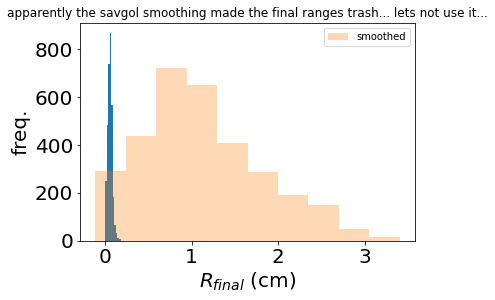

In [94]:
#DONE: try subtracting off the first value of R_nosavgol
plt.hist(dfr.loc[dfr['tdeath']==0,'R_nosavgol'].values.get(),alpha=1.)
plt.hist(dfr.loc[dfr['tdeath']==0,'R'].values.get(),alpha=0.3,label='smoothed')
format_plot(ax=plt.gca(), xlabel=r'$R_{final}$ (cm)', ylabel='freq.', fontsize=20)
plt.title(f'apparently the savgol smoothing made the final ranges trash... lets not use it...')
plt.legend()
plt.show()

In [99]:
dfr=dfr.set_index(['event_id_int','pid_self','pid_other']).to_pandas()
df_r0=dfr.loc[dfr['tdeath']==0,'R_nosavgol']
#subtract off zero without savgol
dfr['R_nosavgol0']=df_r0
dfr['R_nosavgol0']=dfr['R_nosavgol']-dfr['R_nosavgol0']
#subtract off zero with savgol
df_r0=dfr.loc[dfr['tdeath']==0,'R']
dfr['R0']=df_r0
dfr['R0']=dfr['R']-dfr['R0']
dfr.reset_index(inplace=True)

use_subtract_Rfinal=True
if use_subtract_Rfinal:
    dfr['SR']=dfr['R_nosavgol0']**2  #looks nice but the values are too small to be reasonable
    dfr['SR']=dfr['R0']**2 #does not work reasonably well
else:
    dfr['SR']=dfr['R_nosavgol']**2  #works reasonably well
    dfr['SR']=dfr['R']**2  #does not work reasonably well

mean_R_vs_tdeath=dfr.groupby('tdeath')[['SR']].describe()['SR'][['mean','count']]

#identify the max tdeath with the max number of counts
tmaxmax=mean_R_vs_tdeath['count'].max()
boo=tmaxmax==mean_R_vs_tdeath['count']
tdeath_values=mean_R_vs_tdeath[boo].index.values.get()+DT
SR_values=mean_R_vs_tdeath[boo]['mean'].values#.get()

KeyError: "None of ['event_id_int', 'pid_self', 'pid_other'] are in the columns"

In [ ]:
assert(np.min(tdeath_values)==DT)

In [ ]:
#compute a using numpy
tmax=40#ms
printing=True
a_SR, Delta_a_SR, Rsq_a_SR = comp_a_SR(tdeath_values,SR_values,tmax)
if printing:
    print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")

In [ ]:
#compute a using numpy
tmax=25#ms
printing=True
a_SR, Delta_a_SR, Rsq_a_SR = comp_a_SR(tdeath_values,SR_values,tmax)
if printing:
    print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")

In [ ]:
#compute a using numpy
tmax=5#ms
printing=True
a_SR, Delta_a_SR, Rsq_a_SR = comp_a_SR(tdeath_values,SR_values,tmax)
if printing:
    print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")

In [ ]:
num_trials

In [ ]:
print(f"Record This:")
print(f"N_trials,tmax,a={(num_trials,tmax,a_SR)}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")

In [96]:
#compute a versus tmax
tmax_values=np.arange(9*DT,tmaxmax,DT)
a_SR_lst=[];Delta_a_SR_lst=[];Rsq_a_SR_lst=[]
for tmax in tmax_values:
    a_SR, Delta_a_SR, Rsq_a_SR = comp_a_SR(tdeath_values,SR_values,tmax)
    #record results
    a_SR_lst.append(a_SR)
    Delta_a_SR_lst.append(Delta_a_SR)
    Rsq_a_SR_lst.append(Rsq_a_SR)

a_SR_values=np.array(a_SR_lst)
Delta_a_SR_values=np.array(Delta_a_SR_lst)

AssertionError: 

In [72]:
# #DONE: bootstrap Delta_SR_values
# Delta_SR_values=SR_values*0.05

In [73]:
# Delta_SR_lst=[]
# for t in tdeath_values:
#     x=dfr.loc[dfr['tdeath']==t,'SR'].values.get()
#     Delta_x=bootstrap_stdev_of_mean(x=g['SR'].values,num_samples=1000)
#     Delta_SR_lst.append(Delta_x)
df_r=dfr.to_pandas()
routine_bootstrap_tdeath_group=get_routine_bootstrap_tdeath_group(df_r,num_samples=1000)

In [74]:
npartitions=os.cpu_count()
#all CPU version
b = db.from_sequence(tdeath_values, npartitions=npartitions).map(routine_bootstrap_tdeath_group)
start = time.time()
retval = list(b)
if printing:
    print(f"run time for bootstrapping each time value was {time.time()-start:.2f} seconds.")

df_boostrapped=pd.DataFrame(data=np.array(retval), columns=['tdeath','Delta_SR','p_SR'])

run time for bootstrapping each time value was 3.62 seconds.


In [75]:
Delta_SR_values=df_boostrapped['Delta_SR'].values
#apparently all bootstrapped mean values are significantly different from the normal distribution for the full simulation...
percent_normal=sum(df_boostrapped['p_SR']>0.05)/df_boostrapped['p_SR'].shape[0]*100
print(f"percent of normally distributed time bins appears to be {percent_normal:.3f}%")

Delta_SR_values=df_boostrapped['Delta_SR'].values

percent of normally distributed time bins appears to be 67.500%


In [83]:
title_string=f"a=5 cm^2/s, D=0.7 cm^2/s"
# input_folder=os.path.dirname(input_fn_lst[0])
# title_string=input_folder+'\n'

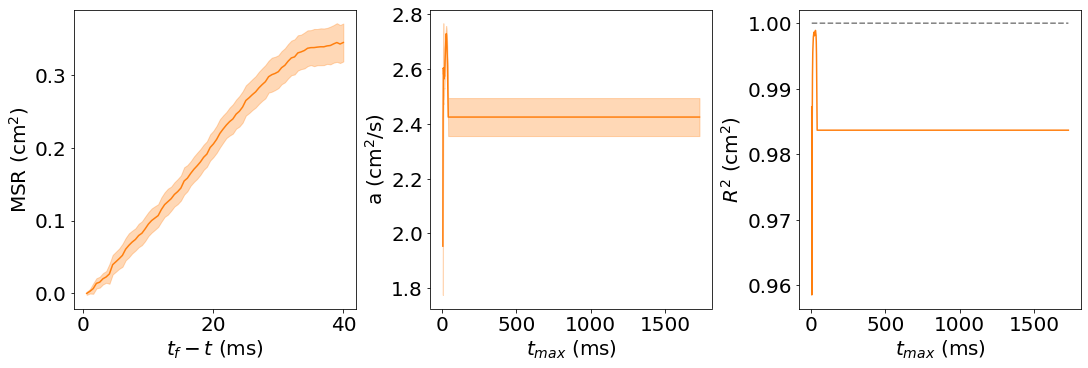

In [86]:
fontsize=20
c='C1'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True)#,ncols=3)#, sharex=True)
ax1.plot(tdeath_values,SR_values,c=c)
ax1.fill_between(tdeath_values,SR_values-Delta_SR_values,SR_values+Delta_SR_values,alpha=0.3,color=c)
ax2.plot(tmax_values,a_SR_lst,c=c)
ax2.fill_between(tmax_values,a_SR_values-Delta_a_SR_values,a_SR_values+Delta_a_SR_values,alpha=0.3,color=c)
# ax2.plot(tmax_values,0.*tmax_values+5,'C--')
ax3.plot(tmax_values,Rsq_a_SR_lst,c=c)
ax3.plot(tmax_values,0.*tmax_values+1.,'gray',linestyle='dashed')
format_plot(ax=ax1, xlabel=r'$t_{f}-t$ (ms)', ylabel=r'MSR (cm$^2$)', fontsize=fontsize, use_loglog=False)
format_plot(ax=ax2, xlabel=r'$t_{max}$ (ms)', ylabel=r'a (cm$^2$/s)', fontsize=fontsize, use_loglog=False)
format_plot(ax=ax3, xlabel=r'$t_{max}$ (ms)', ylabel=r'$R^2$ (cm$^2$)', fontsize=fontsize, use_loglog=False)
# # plt.tight_layout()
# # ax1.set_xlim([0,40])
# # ax1.set_ylim([0,.1])
# ax1.set_xlim([0,5])
# ax1.set_ylim([0,.02])
# ax2.set_ylim([0,0.8])
# fig.suptitle(title_string,fontsize=fontsize)#, fontweight='bold')
plt.show()

In [87]:
if printing:
    print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")

a=2.4248+-0.0693 cm^2/s. (R^2=0.9837)


a=2.7139+-0.0311 cm^2/s. (R^2=0.9984)


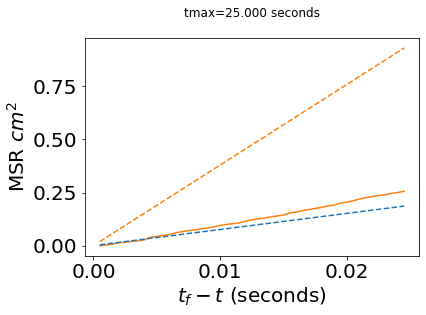

In [90]:
c='C1'
#DONE: compute a using numpy
tmax=25#ms
boo=tdeath_values<tmax
x=tdeath_values[boo]/1000 #s
y=SR_values[boo]# cm^2
dict_force_fit=compute_95CI_ols(x,y)
a_SR=dict_force_fit['m']/4
Delta_a_SR=dict_force_fit['Delta_m']/4
Rsq_a_SR=dict_force_fit['Rsquared']

fontsize=20
plt.plot(x,y,c)
plt.plot(x,x*1.9*4,'C0--')
plt.plot(x,x*9.5*4,'C1--')
# plt.plot(x,x*5*4,'C3--')

# print_dict(dict_force_fit)
format_plot(ax=plt.gca(), xlabel=r'$t_f-t$ (seconds)', ylabel=r'MSR $cm^2$', fontsize=fontsize, use_loglog=False)
# format_plot(ax=plt.gca(), xlabel=r'$t_f-t$ (seconds)', ylabel=r'$R^2$ $cm^2$', fontsize=fontsize, use_loglog=False)
print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")
plt.title(f'tmax={tmax:.3f} seconds\n')
plt.show()

In [47]:
#DONE: compute mean squared range
#DONE: bootstrap 95% CI for R for each tdeath value
#DONE: repeat for R_nosavgol
#DONE: repeat for R subtracting off the initial value for each annihilation event
#DONE: compute a, Delta_a and Rsquared versus tmax using OLS from tdeath=0 to tdeath=tmax
#TODO: return a, Delta_a and Rsquared versus tmax for placement in a pandas dataframe
#TODO: generate ^that pandas dataframe for an array of values for tavg1 without subtracing off the mean of Rsq
#TODO: generate ^that pandas dataframe for an array of values for tavg1 with subtracing off the mean of Rsq
#TODO: plot a_SR from tmax=0.2 seconds versus tavg1
#TODO: save bluf to .pdf

# DONE: plot/experiment on the attraction coefficient versus tavg1 for the particle model

In [7]:
#neighbors=1
input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0_L_10_kappa_1500_varkappa_5_N_2/Log/pbc_particle_log2_log.csv' 
# input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv'  
# input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv'


#neighbors=0
# input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/smoothed_annihilations_tavg1_4.0_tavg2_14.25_maxdtmax_0_maxRfin_0.2_mindur_15/pbc_particle_log8_log_smoothed_annihilations_denoised.csv'
input_fn_lst=get_all_files_matching_pattern(input_fn,'.csv')
len(input_fn_lst)

max_numfiles=50
input_fn_lst=input_fn_lst[:max_numfiles]

In [8]:
# #neighbors=1
# input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv'
# #neighbors=0
# # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log5_log.csv'
df=pd.read_csv(input_fn)
pid_col='pid_explicit'
t_col='t'
DT=np.around(get_DT(df,pid_col=pid_col),7)
tavg1_values=np.arange(0,20,4*DT)
tmax=25#ms
printing=True
use_subtract_Rfinal=True
use_savgol=False
tavg2=14

In [9]:
routine_postprocess_trajectory_folder

<function lib.rapids_func.routines.postprocess_trajectories_cu.routine_postprocess_trajectory_folder(input_fn, DT, tavg1, tavg2=24, max_dtmax_thresh=0, max_Rfinal_thresh=0.2, min_duration_thresh=40, npartitions=None, width=200, height=200, ds=5, use_drop_shorter_than=True, drop_shorter_than=50, tmin=100.0, pid_col='particle', t_col='t', printing=False, printing_routine=False, printing_routine2=False, npartitions2=None, max_num_trials=None, **kwargs)>

In [10]:
def return_attraction_coefficient_for_tavg1_values(input_fn,
        tavg1_values, tavg2, DT, use_subtract_Rfinal, use_savgol, printing, ds,
        width, height, max_dtmax_thresh, max_Rfinal_thresh,
        min_duration_thresh, use_drop_shorter_than, drop_shorter_than, tmin, t_col, pid_col, tmax, 
                                                   max_num_trials=None,**kwargs):
    #compute the attraction coefficient at a long max observation time versus tavg1
    a_SR_lst = []
    Delta_a_SR_lst = []
    Rsq_a_SR_lst = []
    for tavg1 in tavg1_values:
        #perform the postprocessing routine for a given averaging window
        retval = routine_postprocess_trajectory_folder(
            input_fn=input_fn,
            DT=DT,
            tavg1=tavg1,
            tavg2=tavg2,
            max_dtmax_thresh=max_dtmax_thresh,#0,  #ms
            max_Rfinal_thresh=max_Rfinal_thresh,#0.2,  #cm
            min_duration_thresh=min_duration_thresh,#15,  #ms #sets maximum tdeath?
            npartitions=1,
            width=width, #10,
            height=height, #10,
            ds=ds, #10,
            use_drop_shorter_than=use_drop_shorter_than, #False,
            drop_shorter_than=drop_shorter_than,#0,  #ms
            tmin=tmin,#0.,  #ms
            pid_col=pid_col,
            t_col=t_col,
            printing=False,
        max_num_trials=max_num_trials)
        save_dir_lst, save_dir_lst2 = retval
        dir_lst = [
            fn for fn in save_dir_lst2 if type(fn) == type('any string')
        ]
        dir_missing_lst = [
            fn for fn in dir_lst if not os.path.exists(fn)
        ]
        if len(dir_missing_lst)>0:
            print(len(dir_missing_lst))
            print(dir_missing_lst[0])
        #load the resulting folder of csv data
        dfr = dask_cudf.read_csv(dir_lst).compute()
        #     DT=get_DT_cu(dfr, t_col='t', pid_col='pid_self', round_digits=7)
        dfr = dfr.sort_values(by=['event_id_int', 'pid_self', 'tdeath'],
                              ascending=True)

        dfr = dfr.set_index(['event_id_int', 'pid_self', 'pid_other'])
        
#         def compute_MSR_values(dfr,DT,):
        df_r0 = dfr.loc[dfr['tdeath'] == 0, 'R_nosavgol']
        #subtract off zero without savgol
        dfr['R_nosavgol0'] = df_r0
        dfr['R_nosavgol0'] = dfr['R_nosavgol'] - dfr['R_nosavgol0']
        #subtract off zero with savgol
        df_r0 = dfr.loc[dfr['tdeath'] == 0, 'R']
        dfr['R0'] = df_r0
        dfr['R0'] = dfr['R'] - dfr['R0']
        dfr.reset_index(inplace=True)

        if use_subtract_Rfinal:
            if not use_savgol:
                dfr['SR'] = dfr[
                    'R_nosavgol0']**2  #looks nice but the values are too small to be reasonable
            else:
                dfr['SR'] = dfr['R0']**2  #does not work reasonably well
        else:
            if not use_savgol:
                dfr['SR'] = dfr['R_nosavgol']**2  #works reasonably well
            else:
                dfr['SR'] = dfr['R']**2  #does not work reasonably well

        mean_R_vs_tdeath = dfr.groupby('tdeath')[['SR']].describe()['SR'][[
            'mean', 'count'
        ]]

        #identify the max tdeath with the max number of counts
        tmaxmax = mean_R_vs_tdeath['count'].max()
        boo = tmaxmax == mean_R_vs_tdeath['count']
        tdeath_values = mean_R_vs_tdeath[boo].index.values.get() + DT
        SR_values = mean_R_vs_tdeath[boo]['mean'].values.get()
        
        #compute the attraction coefficient using OLS
        a_SR, Delta_a_SR, Rsq_a_SR = comp_a_SR(tdeath_values, SR_values, tmax)
        if printing:
            print(
                f"tavg1={tavg1}: a={a_SR:.7f}+-{Delta_a_SR:.7f} cm^2/s (R^2={Rsq_a_SR:.7f})"
            )

        #record
        a_SR_lst.append(a_SR)
        Delta_a_SR_lst.append(Delta_a_SR)
        Rsq_a_SR_lst.append(Rsq_a_SR)
    a_SR_values = np.array(a_SR_lst)
    Delta_a_SR_values = np.array(Delta_a_SR_lst)
    Rsq_a_SR_values = np.array(Rsq_a_SR_lst)
    return a_SR_values, Delta_a_SR_values, Rsq_a_SR_values

In [11]:
# a_SR_values=np.array(a_SR_lst)
# Delta_a_SR_values=np.array(Delta_a_SR_lst)
# Rsq_a_SR_values=np.array(Rsq_a_SR_lst)
1

1

In [12]:
def gener_attraction_coefficient_figure(ax2, ax3, a_SR_values, Delta_a_SR_values, Rsq_a_SR_values, fontsize=20):
    # ax1.plot(tdeath_values,SR_values)
    # ax1.fill_between(tdeath_values,SR_values-Delta_SR_values,SR_values+Delta_SR_values,alpha=0.3)
    ax2.plot(tavg1_values,a_SR_values)
    ax2.fill_between(tavg1_values,a_SR_values-Delta_a_SR_values,a_SR_values+Delta_a_SR_values,alpha=0.3)
    ax2.plot(tavg1_values,0.*tavg1_values+5,'C3--')
    ax3.plot(tavg1_values,Rsq_a_SR_values)
    ax3.plot(tavg1_values,0.*tavg1_values+1.,'gray',linestyle='dashed')
    # format_plot(ax=ax1, xlabel=r'$t_{f}-t$ (ms)', ylabel=r'MSR (cm$^2$)', fontsize=fontsize, use_loglog=False)
    format_plot(ax=ax2, xlabel=r'$t_{avg1}$ (ms)', ylabel=r'a (cm$^2$/s)', fontsize=fontsize, use_loglog=False)
    format_plot(ax=ax3, xlabel=r'$t_{avg1}$ (ms)', ylabel=r'$R^2$ (cm$^2$)', fontsize=fontsize, use_loglog=False)

## experiment on the particle model

In [13]:
printing=True
kwargs=dict(printing=printing, ds=10,
        width=10, height=10, max_dtmax_thresh=0, max_Rfinal_thresh=0.2,
        min_duration_thresh=15, use_drop_shorter_than=False, drop_shorter_than=0, tmin=0,pid_col='pid_explicit',
        t_col='t', tavg2=14, tmax=25, max_num_trials=None)

In [15]:
1

1

In [ ]:
a_SR_values, Delta_a_SR_values, Rsq_a_SR_values=return_attraction_coefficient_for_tavg1_values(input_fn=input_fn,tavg1_values=tavg1_values, DT=DT, use_subtract_Rfinal=use_subtract_Rfinal, use_savgol=use_savgol, **kwargs)    


In [14]:
# #parameterize the different methods, holding tavg2=14 ms fixed and varying tavg1 from 0 to 20 ms
# use_subtract_Rfinal=True
# use_savgol=True
# a_SR_values, Delta_a_SR_values, Rsq_a_SR_values=return_attraction_coefficient_for_tavg1_values(input_fn=input_fn,tavg1_values=tavg1_values, DT=DT, use_subtract_Rfinal=use_subtract_Rfinal, use_savgol=use_savgol, **kwargs)    
# fig, (ax2, ax3) = plt.subplots(figsize=(10,5), ncols=2)#, sharex=True)
# gener_attraction_coefficient_figure(ax2, ax3, a_SR_values, Delta_a_SR_values, Rsq_a_SR_values, fontsize=20)
# plt.title(f"use_subtract_Rfinal={use_subtract_Rfinal}, use_savgol={use_savgol}\n")
# plt.tight_layout()
# plt.show()

use_subtract_Rfinal=False
use_savgol=False
print(f"use_subtract_Rfinal={use_subtract_Rfinal}, use_savgol={use_subtract_Rfinal}")
a_SR_values, Delta_a_SR_values, Rsq_a_SR_values=return_attraction_coefficient_for_tavg1_values(input_fn=input_fn,tavg1_values=tavg1_values, DT=DT, use_subtract_Rfinal=use_subtract_Rfinal, use_savgol=use_savgol, **kwargs)    
fig, (ax2, ax3) = plt.subplots(figsize=(10,5), ncols=2)#, sharex=True)
gener_attraction_coefficient_figure(ax2, ax3, a_SR_values, Delta_a_SR_values, Rsq_a_SR_values, fontsize=20)
plt.title(f"use_subtract_Rfinal={use_subtract_Rfinal}, use_savgol={use_savgol}\n")
plt.tight_layout()
plt.show()


use_subtract_Rfinal=False
use_savgol=True
print(f"use_subtract_Rfinal={use_subtract_Rfinal}, use_savgol={use_subtract_Rfinal}")
a_SR_values, Delta_a_SR_values, Rsq_a_SR_values=return_attraction_coefficient_for_tavg1_values(input_fn=input_fn,tavg1_values=tavg1_values, DT=DT, use_subtract_Rfinal=use_subtract_Rfinal, use_savgol=use_savgol, **kwargs)    
fig, (ax2, ax3) = plt.subplots(figsize=(10,5), ncols=2)#, sharex=True)
gener_attraction_coefficient_figure(ax2, ax3, a_SR_values, Delta_a_SR_values, Rsq_a_SR_values, fontsize=20)
plt.title(f"use_subtract_Rfinal={use_subtract_Rfinal}, use_savgol={use_savgol}\n")
plt.tight_layout()
plt.show()

use_subtract_Rfinal=True
use_savgol=False
print(f"use_subtract_Rfinal={use_subtract_Rfinal}, use_savgol={use_subtract_Rfinal}")
a_SR_values, Delta_a_SR_values, Rsq_a_SR_values=return_attraction_coefficient_for_tavg1_values(input_fn=input_fn,tavg1_values=tavg1_values, DT=DT, use_subtract_Rfinal=use_subtract_Rfinal, use_savgol=use_savgol, **kwargs)    
fig, (ax2, ax3) = plt.subplots(figsize=(10,5), ncols=2)#, sharex=True)
gener_attraction_coefficient_figure(ax2, ax3, a_SR_values, Delta_a_SR_values, Rsq_a_SR_values, fontsize=20)
plt.title(f"use_subtract_Rfinal={use_subtract_Rfinal}, use_savgol={use_savgol}\n")
plt.tight_layout()
plt.show()



use_subtract_Rfinal=False, use_savgol=False


FileNotFoundError: A file in: [] does not exist.

In [28]:
beep(5)



0

## Repeat tavg1 variation experiment for 1 run for either of the full models

In [143]:
input_fn=search_for_file('/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.001')

File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffcoef_0.001/trajectories/ic200x200.0.6_traj_sr_400_mem_0.csv


In [16]:
print(f" ********************************************\n *** starting experiment for LR low res...***")
#LR low res
input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv'
#FK low res
# input_fn= '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv'
#FK high res
# input_fn= '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/trajectories/ic200x200.0.8_traj_sr_600_mem_0.csv'

input_input_fn_lst=[
    '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv',
    "/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffcoef_0.001/trajectories/ic200x200.0.6_traj_sr_400_mem_0.csv",
# DVmem is too little    '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv',
# too much data    '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/trajectories/ic200x200.0.8_traj_sr_600_mem_0.csv',
]
input_label_lst=[
    f" ********************************************\n *** starting experiment for LR low res...***",
    f" ********************************************\n *** starting experiment for FK low res...***",
#     f" ********************************************\n *** starting experiment for FK high res..***"
]
input_fn=input_input_fn_lst[0]
assert(os.path.exists(input_fn))
df=pd.read_csv(input_fn)
DT=np.around(get_DT(df,pid_col='particle'),7)
tavg1_values=np.arange(0,22,4*DT)
# tavg1_values=np.arange(0,20,4*DT)
print(tavg1_values)
use_subtract_Rfinal=True
use_savgol=False

 ********************************************
 *** starting experiment for LR low res...***
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]


In [25]:
printing=True
kwargs=dict(printing=printing, ds=5,
        width=200, height=200, max_dtmax_thresh=0, max_Rfinal_thresh=0.2,
        min_duration_thresh=20, use_drop_shorter_than=True, drop_shorter_than=40, tmin=100,pid_col='particle',
        t_col='t', tavg2=14, tmax=25)#1000)#
# printing=True
# kwargs=dict(printing=printing, ds=5,
#         width=200, height=200, max_dtmax_thresh=0, max_Rfinal_thresh=0.2,
#         min_duration_thresh=40, use_drop_shorter_than=True, drop_shorter_than=40, tmin=100,pid_col='particle',
#         t_col='t', tavg2=14, tmax=25)

In [26]:
# a_SR_values, Delta_a_SR_values, Rsq_a_SR_values=return_attraction_coefficient_for_tavg1_values(input_fn=input_fn,tavg1_values=tavg1_values, DT=DT, use_subtract_Rfinal=use_subtract_Rfinal, use_savgol=use_savgol, **kwargs)

 ********************************************
 *** starting experiment for LR low res...***
tavg1=0.0: a=2.9661480+-0.0340133 cm^2/s (R^2=0.9983938)
tavg1=2.0: a=2.5958861+-0.0204362 cm^2/s (R^2=0.9992423)
tavg1=4.0: a=2.4974629+-0.0155814 cm^2/s (R^2=0.9995240)
tavg1=6.0: a=2.9520023+-0.0314716 cm^2/s (R^2=0.9986114)
tavg1=8.0: a=3.3419097+-0.1313336 cm^2/s (R^2=0.9814553)
tavg1=10.0: a=3.1647957+-0.1532347 cm^2/s (R^2=0.9721178)
tavg1=12.0: a=3.0603334+-0.0951865 cm^2/s (R^2=0.9883026)
tavg1=14.0: a=2.8646343+-0.0872465 cm^2/s (R^2=0.9887787)
tavg1=16.0: a=2.5445278+-0.1198070 cm^2/s (R^2=0.9735933)
tavg1=18.0: a=1.4140989+-0.1097110 cm^2/s (R^2=0.9368781)


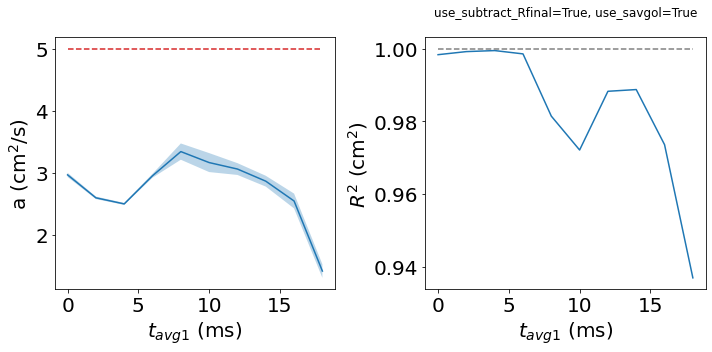

tavg1=0.0: a=0.6814059+-0.0249640 cm^2/s (R^2=0.9838442)
tavg1=2.0: a=1.2136297+-0.0203246 cm^2/s (R^2=0.9965805)
tavg1=4.0: a=1.1725654+-0.0505630 cm^2/s (R^2=0.9777563)
tavg1=6.0: a=1.7923562+-0.1760296 cm^2/s (R^2=0.8944486)
tavg1=8.0: a=2.7624912+-0.1698762 cm^2/s (R^2=0.9557811)
tavg1=10.0: a=4.0375116+-0.1683457 cm^2/s (R^2=0.9791732)
tavg1=12.0: a=4.8396234+-0.1512399 cm^2/s (R^2=0.9881931)
tavg1=14.0: a=4.7005942+-0.2099515 cm^2/s (R^2=0.9761743)
tavg1=16.0: a=3.7578442+-0.1428801 cm^2/s (R^2=0.9826205)
tavg1=18.0: a=2.4848587+-0.1506876 cm^2/s (R^2=0.9604643)


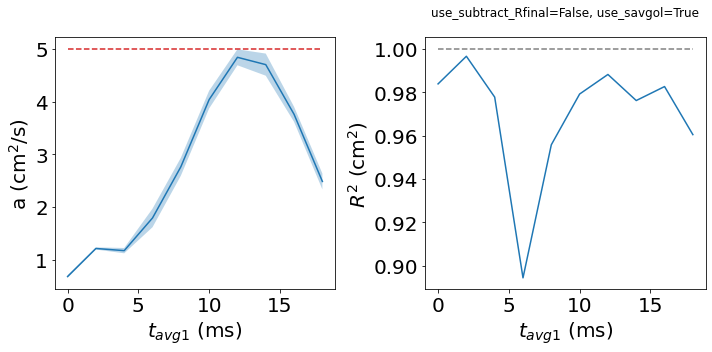

tavg1=0.0: a=4.2285672+-0.0886969 cm^2/s (R^2=0.9946459)
tavg1=2.0: a=4.0964857+-0.1413067 cm^2/s (R^2=0.9856513)
tavg1=4.0: a=3.8705749+-0.2109489 cm^2/s (R^2=0.9649339)
tavg1=6.0: a=3.7207074+-0.1999429 cm^2/s (R^2=0.9658754)
tavg1=8.0: a=3.5285207+-0.1834216 cm^2/s (R^2=0.9679981)
tavg1=10.0: a=3.6033901+-0.1669526 cm^2/s (R^2=0.9744088)
tavg1=12.0: a=2.9659126+-0.1256028 cm^2/s (R^2=0.9785295)
tavg1=14.0: a=2.8926453+-0.1451320 cm^2/s (R^2=0.9701222)
tavg1=16.0: a=2.5312672+-0.1239590 cm^2/s (R^2=0.9714959)
tavg1=18.0: a=1.4454959+-0.1137738 cm^2/s (R^2=0.9351530)


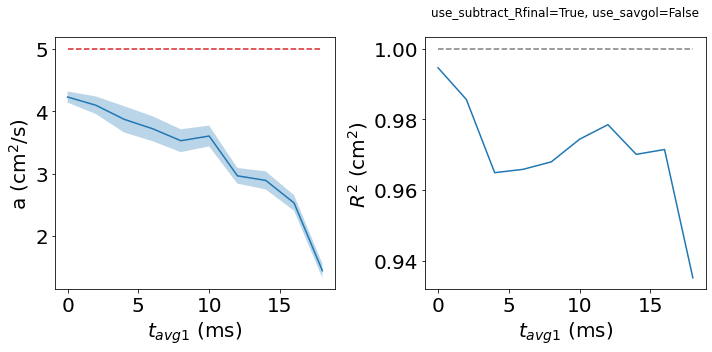

tavg1=0.0: a=5.5273233+-0.0502060 cm^2/s (R^2=0.9989916)
tavg1=2.0: a=5.9832239+-0.0726470 cm^2/s (R^2=0.9981996)
tavg1=4.0: a=5.9394872+-0.1747492 cm^2/s (R^2=0.9895204)
tavg1=6.0: a=5.7774346+-0.1652755 cm^2/s (R^2=0.9900870)
tavg1=8.0: a=5.4559697+-0.1537317 cm^2/s (R^2=0.9903801)
tavg1=10.0: a=5.3443657+-0.1748289 cm^2/s (R^2=0.9870768)
tavg1=12.0: a=4.4431747+-0.1406251 cm^2/s (R^2=0.9878931)
tavg1=14.0: a=4.2648381+-0.1517534 cm^2/s (R^2=0.9847461)
tavg1=16.0: a=3.7457441+-0.1493385 cm^2/s (R^2=0.9809239)
tavg1=18.0: a=2.4731454+-0.1459811 cm^2/s (R^2=0.9624651)


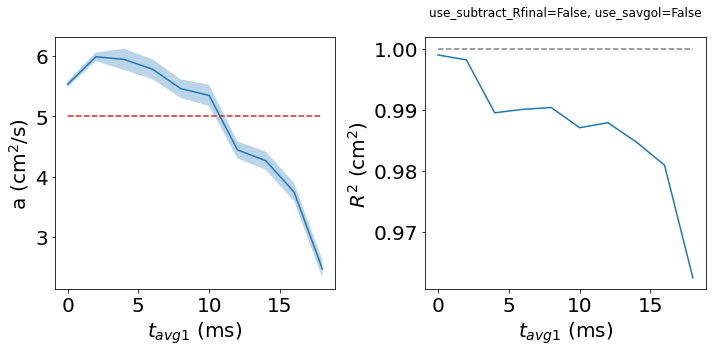

 ********************************************
 *** starting experiment for FK low res...***
tavg1=0.0: a=2.5069630+-0.0241938 cm^2/s (R^2=0.9988377)
tavg1=1.6: a=2.8168891+-0.0628314 cm^2/s (R^2=0.9938219)
tavg1=3.2: a=2.9044075+-0.0651797 cm^2/s (R^2=0.9933584)
tavg1=4.800000000000001: a=2.0128693+-0.0592993 cm^2/s (R^2=0.9886093)
tavg1=6.4: a=1.2259611+-0.0319452 cm^2/s (R^2=0.9895066)
tavg1=8.0: a=1.1150049+-0.0419609 cm^2/s (R^2=0.9783592)
tavg1=9.600000000000001: a=0.7396176+-0.0289686 cm^2/s (R^2=0.9766010)
tavg1=11.200000000000001: a=0.7498631+-0.0354459 cm^2/s (R^2=0.9662782)
tavg1=12.8: a=0.5114316+-0.0228736 cm^2/s (R^2=0.9697050)
tavg1=14.4: a=0.5393801+-0.0288880 cm^2/s (R^2=0.9571203)
tavg1=16.0: a=0.6107730+-0.0319080 cm^2/s (R^2=0.9617376)
tavg1=17.6: a=0.7421011+-0.0379717 cm^2/s (R^2=0.9657737)
tavg1=19.200000000000003: a=0.4994069+-0.0267319 cm^2/s (R^2=0.9654376)


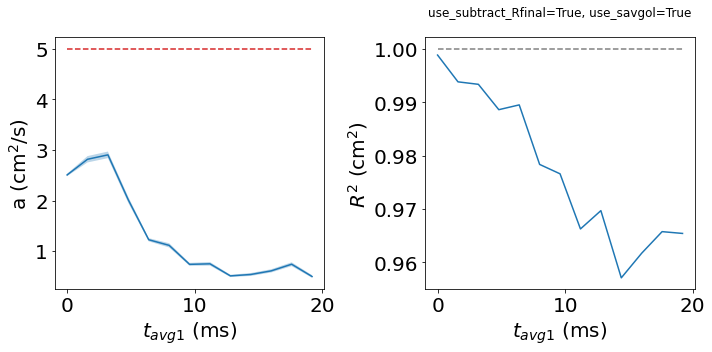

tavg1=0.0: a=1.3084348+-0.0875015 cm^2/s (R^2=0.9470773)
tavg1=1.6: a=1.7616313+-0.0986775 cm^2/s (R^2=0.9622745)
tavg1=3.2: a=3.0752814+-0.0802508 cm^2/s (R^2=0.9910406)
tavg1=4.800000000000001: a=3.1191894+-0.0567063 cm^2/s (R^2=0.9956315)
tavg1=6.4: a=1.5775753+-0.0990341 cm^2/s (R^2=0.9420187)
tavg1=8.0: a=0.8187721+-0.1249280 cm^2/s (R^2=0.7333490)
tavg1=9.600000000000001: a=0.7458169+-0.1319103 cm^2/s (R^2=0.6717831)
tavg1=11.200000000000001: a=0.7814192+-0.0650483 cm^2/s (R^2=0.9023408)
tavg1=12.8: a=1.3145536+-0.0306611 cm^2/s (R^2=0.9915747)
tavg1=14.4: a=1.0949466+-0.0392660 cm^2/s (R^2=0.9803098)
tavg1=16.0: a=0.6481188+-0.0542961 cm^2/s (R^2=0.9071886)
tavg1=17.6: a=1.2870534+-0.0555140 cm^2/s (R^2=0.9754359)
tavg1=19.200000000000003: a=0.2656135+-0.0147806 cm^2/s (R^2=0.9627498)


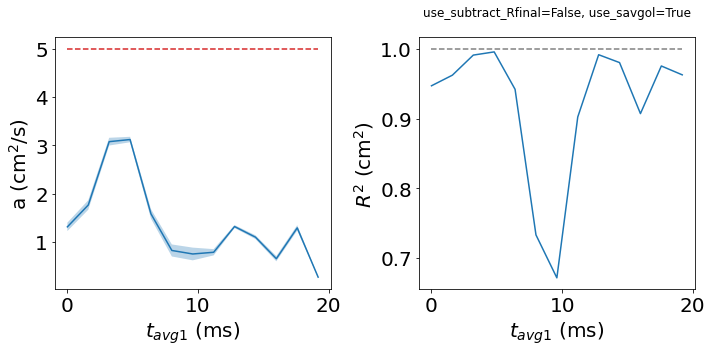

tavg1=0.0: a=5.5765004+-0.1365897 cm^2/s (R^2=0.9925596)
tavg1=1.6: a=4.1937302+-0.0634707 cm^2/s (R^2=0.9971461)
tavg1=3.2: a=3.5937496+-0.0727606 cm^2/s (R^2=0.9945875)
tavg1=4.800000000000001: a=2.2243025+-0.0580348 cm^2/s (R^2=0.9910435)
tavg1=6.4: a=1.0699002+-0.0317573 cm^2/s (R^2=0.9864261)
tavg1=8.0: a=0.7515411+-0.0260256 cm^2/s (R^2=0.9816145)
tavg1=9.600000000000001: a=0.4554867+-0.0128431 cm^2/s (R^2=0.9877350)
tavg1=11.200000000000001: a=0.3389883+-0.0119506 cm^2/s (R^2=0.9809585)
tavg1=12.8: a=0.3023010+-0.0134950 cm^2/s (R^2=0.9698147)
tavg1=14.4: a=0.2834051+-0.0180568 cm^2/s (R^2=0.9403780)
tavg1=16.0: a=0.2323212+-0.0166567 cm^2/s (R^2=0.9302901)
tavg1=17.6: a=0.2304274+-0.0187426 cm^2/s (R^2=0.9178071)
tavg1=19.200000000000003: a=0.1549068+-0.0152099 cm^2/s (R^2=0.8924914)


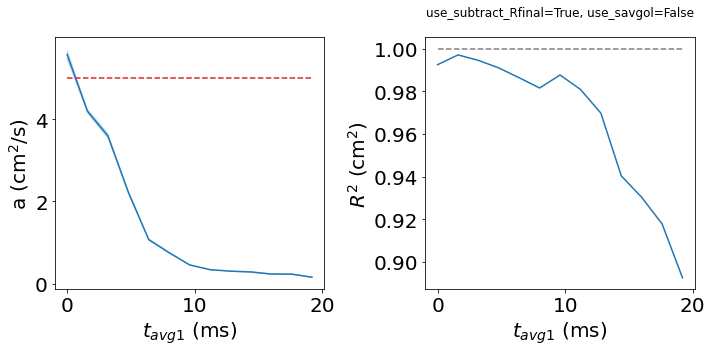

tavg1=0.0: a=8.4197792+-0.4022058 cm^2/s (R^2=0.9722786)
tavg1=1.6: a=6.4619946+-0.2265039 cm^2/s (R^2=0.9848807)
tavg1=3.2: a=5.6436864+-0.1410383 cm^2/s (R^2=0.9917772)
tavg1=4.800000000000001: a=3.5699501+-0.0902684 cm^2/s (R^2=0.9915834)
tavg1=6.4: a=1.7513023+-0.0649570 cm^2/s (R^2=0.9789653)
tavg1=8.0: a=1.2588983+-0.0482338 cm^2/s (R^2=0.9775862)
tavg1=9.600000000000001: a=0.8278073+-0.0353348 cm^2/s (R^2=0.9723306)
tavg1=11.200000000000001: a=0.6638059+-0.0153534 cm^2/s (R^2=0.9917139)
tavg1=12.8: a=0.5857301+-0.0133318 cm^2/s (R^2=0.9919736)
tavg1=14.4: a=0.5470836+-0.0120798 cm^2/s (R^2=0.9924428)
tavg1=16.0: a=0.4829801+-0.0107274 cm^2/s (R^2=0.9928600)
tavg1=17.6: a=0.4934065+-0.0123978 cm^2/s (R^2=0.9915263)
tavg1=19.200000000000003: a=0.3681745+-0.0127649 cm^2/s (R^2=0.9852026)


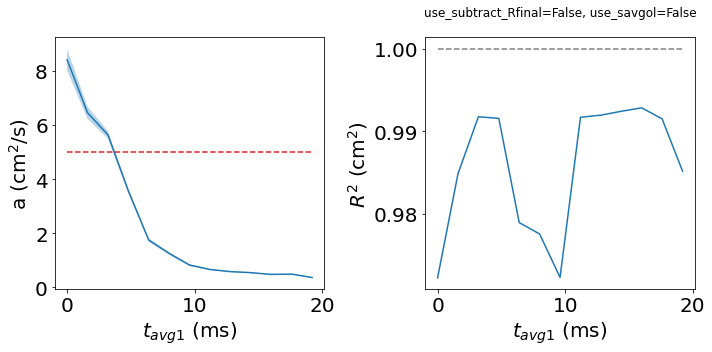

In [27]:
for input_fn,input_label in zip(input_input_fn_lst,input_label_lst):
    print(input_label)
    df=pd.read_csv(input_fn)
    DT=np.around(get_DT(df,pid_col='particle'),7)
    tavg1_values=np.arange(0,20,4*DT)
    #parameterize the different methods, holding tavg2=14 ms fixed and varying tavg1 from 0 to 20 ms
    use_subtract_Rfinal=True
    use_savgol=True
    a_SR_values, Delta_a_SR_values, Rsq_a_SR_values=return_attraction_coefficient_for_tavg1_values(input_fn=input_fn,tavg1_values=tavg1_values, DT=DT, use_subtract_Rfinal=use_subtract_Rfinal, use_savgol=use_savgol, **kwargs)    
    fig, (ax2, ax3) = plt.subplots(figsize=(10,5), ncols=2)#, sharex=True)
    gener_attraction_coefficient_figure(ax2, ax3, a_SR_values, Delta_a_SR_values, Rsq_a_SR_values, fontsize=20)
    plt.title(f"use_subtract_Rfinal={use_subtract_Rfinal}, use_savgol={use_savgol}\n")
    plt.tight_layout()
    plt.show()

    use_subtract_Rfinal=False
    use_savgol=True
    a_SR_values, Delta_a_SR_values, Rsq_a_SR_values=return_attraction_coefficient_for_tavg1_values(input_fn=input_fn,tavg1_values=tavg1_values, DT=DT, use_subtract_Rfinal=use_subtract_Rfinal, use_savgol=use_savgol, **kwargs)    
    fig, (ax2, ax3) = plt.subplots(figsize=(10,5), ncols=2)#, sharex=True)
    gener_attraction_coefficient_figure(ax2, ax3, a_SR_values, Delta_a_SR_values, Rsq_a_SR_values, fontsize=20)
    plt.title(f"use_subtract_Rfinal={use_subtract_Rfinal}, use_savgol={use_savgol}\n")
    plt.tight_layout()
    plt.show()

    use_subtract_Rfinal=True
    use_savgol=False
    a_SR_values, Delta_a_SR_values, Rsq_a_SR_values=return_attraction_coefficient_for_tavg1_values(input_fn=input_fn,tavg1_values=tavg1_values, DT=DT, use_subtract_Rfinal=use_subtract_Rfinal, use_savgol=use_savgol, **kwargs)    
    fig, (ax2, ax3) = plt.subplots(figsize=(10,5), ncols=2)#, sharex=True)
    gener_attraction_coefficient_figure(ax2, ax3, a_SR_values, Delta_a_SR_values, Rsq_a_SR_values, fontsize=20)
    plt.title(f"use_subtract_Rfinal={use_subtract_Rfinal}, use_savgol={use_savgol}\n")
    plt.tight_layout()
    plt.show()

    use_subtract_Rfinal=False
    use_savgol=False
    a_SR_values, Delta_a_SR_values, Rsq_a_SR_values=return_attraction_coefficient_for_tavg1_values(input_fn=input_fn,tavg1_values=tavg1_values, DT=DT, use_subtract_Rfinal=use_subtract_Rfinal, use_savgol=use_savgol, **kwargs)    
    fig, (ax2, ax3) = plt.subplots(figsize=(10,5), ncols=2)#, sharex=True)
    gener_attraction_coefficient_figure(ax2, ax3, a_SR_values, Delta_a_SR_values, Rsq_a_SR_values, fontsize=20)
    plt.title(f"use_subtract_Rfinal={use_subtract_Rfinal}, use_savgol={use_savgol}\n")
    plt.tight_layout()
    plt.show()

# TODO(later): repeat the experiment on the full models and on the particle model with relaxed rules for determining annihilations / with testing for duplicate particles turned off

# etc

In [83]:
input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv'
# pairs_fn=search_for_file(os.path.dirname(os.path.dirname(input_fn)))
df_fn=search_for_file(os.path.dirname(os.path.dirname(input_fn)))

File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_tavg_0.0/ic001.11_traj_sr_600_mem_0_smoothed.csv


In [84]:
pairs_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/pairs_tavg1_0.0_tavg2_14.5_maxdtmax_0_maxRfin_0.2_mindur_40/ic001.33_traj_sr_600_mem_0_smoothed_annihilations_denoised.csv'
df_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_tavg_0.0/ic001.11_traj_sr_600_mem_0_smoothed.csv'
df=cudf.read_csv(df_fn)
df.head()

,index,x,y,t,particle,event_id_int,dx_unwrap,dy_unwrap
0,3,199.825274,101.993850,100.0,3,1001116000,0.0,0.0
1,6,199.496278,102.185605,100.5,3,1001116000,0.0,0.0
2,13,197.782909,102.897178,101.0,3,1001116000,0.0,0.0
3,17,197.416347,102.989611,101.5,3,1001116000,0.0,0.0
4,18,197.042631,103.093649,102.0,3,1001116000,0.0,0.0


In [105]:
pid_col='particle'
minimum_duration_threshold=0
width=200;height=200;ds=5
DS=ds/width
trial_col='event_id_int'


In [90]:
grouped=df.groupby([trial_col,pid_col])
dft=grouped[t_col]
dfu=cudf.DataFrame({
    'tmin':dft.min(),
    'tmax':dft.max(),
})
dfu.reset_index(inplace=True)
df_intersecting_pairs_all=identify_all_coexisting_pairs(df=dfu.copy(),pid_col=pid_col,t_col=t_col,trial_col=trial_col)

#filter by duration_threshold
use_duration_threshold=True
if use_duration_threshold:
    df_pairs=df_intersecting_pairs_all[df_intersecting_pairs_all['duration']>minimum_duration_threshold]
else:
    df_pairs=df_intersecting_pairs_all
#and sort
df_pairs=df_pairs.sort_values([trial_col,'pid_self'], ascending=True).copy()

using 1 cores to identify pairs of particles that coexist over 1 independent trials...


In [106]:
dff = df.set_index([trial_col, pid_col, t_col])
df_pairs = df_intersecting_pairs_all.set_index(
    [trial_col, 'pid_self', 'tmax']).copy()
df_pairs[['x_self', 'y_self']] = dff.loc[df_pairs.index][['x', 'y']]
df_pairs = df_pairs.reset_index().set_index(
    [trial_col, 'pid_other', 'tmax'])
df_pairs[['x_other', 'y_other']] = dff.loc[df_pairs.index][['x', 'y']]
df_pairs = comp_xy_distance_L2_pbc_cu(df_pairs, width, height)
df_pairs['Rfinal'] = df_pairs['dist'] * DS
df_pairs = df_pairs.reset_index().set_index(
    [trial_col, 'pid_self', 'pid_other'])
#compute the difference in time between the last observation of either particle
df_pairs['dtmax'] = cp.abs(df_pairs['tmax_self'] - df_pairs['tmax_other'])

In [120]:
se={}

AttributeError: 'dict' object has no attribute 'difference'

True

In [124]:
# def drop_any_duplicate_pairs(df_pairs, testing=True, trial_col='event_id_int', **kwargs):
#     if testing:
#         #TODO: identify any repeated particles that are repeated
#         df_pairs = df_pairs.reset_index().set_index(
#             [trial_col, 'pid_self', 'pid_other'])
#         piv = df_pairs.index.values
#         trial_lst = sorted(set(piv[:, 0].get()))
#         for trial in trial_lst:
#             iv = piv[piv[:, 0] == trial][:, 1:]
#             #ensure that no particle appears twice in iv
#             total_num_pair_members = iv.flatten().shape[0]
#             unique_member_lst=list(set(iv.flatten().get()))
#             no_duplicates_exist = total_num_pair_members == len(unique_member_lst)

#             if not no_duplicates_exist:
#                 Rfinal_is_in_col_lst={'Rfinal'}.issubset(set(df_pairs.columns))
#                 if not Rfinal_is_in_col_lst:
#                     raise("Warning: Rfinal missing from column list!")
#                 #build a new df_pairs from the ground up by selecting the minimum final range indicies
#                 dfp=df_pairs.reset_index()
#                 id_keep_lst=[]
#                 for member_id in unique_member_lst:
#                     boo=(dfp['pid_self']==member_id)|(dfp['pid_other']==member_id)
#                     id_keep=int(dfp[boo].sort_values(by='Rfinal').head(1).index.values.get())
#                     id_keep_lst.append(id_keep)

#                 df_pairs=dfp.iloc[id_keep_lst].copy()

#         #         #TODO: identify the duplicated particle
#         #         #TODO: select all entries in df_pairs that involve the duplicated particle
#         #         #TODO: select the particle pair that is nearest
#         #         print(
#         #             "Warning: duplicate particles detected but not removed!  TODO: Implement the 3 comments above!"
#         #         )

#         #     assert (no_duplicates_exist)
#     return df_pairs



In [91]:
# df_pairs=cudf.read_csv(pairs_fn)
drop_any_duplicate_pairs(df_pairs)

AssertionError: 

In [9]:
# #TODO(later): compute squared displacements
# grouped=df.groupby(pid_col)
# #HINT: squared displacements of particles is result
#  throws AttributeError: DataFrameGroupBy object has no attribute first 
# result = (grouped[['x','y']]-grouped[['x','y']].first())**2

In [10]:
#TODO(later): implement a one_step method on an element in a finite element simulation
# HINT: cudf.Grouper?
# HINT: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#grouping-with-a-grouper-specification
# HINT: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#transformation

In [11]:
#DONE: figure out if there's an elegant was to use the cudf api  to do this
#for each group of event_id_int's :
#compare every particle to every other particle in a simple way
#compare every particle to every other particle to determine if the self,other pair intersects nontrivially

#DONE: determine condition for whether each pair is intersecting for at least two times 
# two particles exist for at least two times if both
#if other has a tmin > tmin of self
#AND if other has a tmax < tmax of self, 

# #DONE: construct the graph of all edges... this wasn't useful...
# G = cugraph.Graph()
# G.from_cudf_edgelist(df_pairs, source='src', destination='dst', edge_attr='dst')
# # # Let's now get the PageRank score of each vertex by calling cugraph.pagerank
# # df_page = cugraph.pagerank(G)
# # df_page.head()

In [12]:
#DONE: compute which edges are intersecting
#DONE: compute tmin and tmax for each intersecting edge
#DONE: compute duration for each intersecting edge
#DONE: sort edges by duration
#DONE: visualize the histogram of durations of intersecting edges
#DONE: consider a minimum_duration_threshold that is at least tavg2 if not specified

## scratchwerk

In [13]:
#DONT: figure out terrible numba debugging for a negligible speed boost
# @cuda.jit()#device=True)
# def distance_L2_pbc_cuda(point_1, point_2, dist_out, shape):
#     '''distance_L2_pbc_cu is a jit compiled function that 
#     returns for the euclidean (L2) distance between 
#     point_1 and point_2, which are in an N-cube of shape shape 
#     with periodic boundary conditions
    
#     Example Usage:
#     blockspergrid=1
#     threadsperblock=1
#     point_1=self_values[0]
#     point_2=other_values[0]
#     dist_out=0.#overwritten
#     shape=(width,height)
#     distance_L2_pbc_cuda[blockspergrid, threadsperblock](point_1, point_2, dist_out, shape)
#     '''
#     dq2 = 0.
#     for q1, q2, wid in zip(point_1, point_2, shape):
#         dq2 = dq2 + min(((q2 - q1)**2, (q2 + wid - q1 )**2, (q2 - wid - q1 )**2))
#     dist_out= dq2**0.5

# blockspergrid=1
# threadsperblock=1
# point_1=self_values[0]
# point_2=other_values[0]
# dist_out=np.array([0.])#*self_values
# shape=(width,height)
# # distance_L2_pbc_cuda(point_1, point_2, dist_out, shape)
# distance_L2_pbc_cuda[blockspergrid, threadsperblock](point_1, point_2, dist_out, shape)
# dist_out, point_1, point_2

# from numba import vectorize
# # shape=(width,height)
# # @vectorize(['float32[:](float32, float32, float32)'], target='cuda')
# shape=cp.array((width,height))
# @vectorize(['(float32[:,:], float32[:,:], float32[:,:], float32[:])'], target='cuda')
# def distance_L2_pbc_cu(self_values, other_values, dist_out_values, shape):
#     for point_1, point_2, dist_out in zip(self_values, other_values, dist_out_values):
#         distance_L2_pbc_cuda(point_1, point_2, dist_out, shape)

# # blockspergrid=1
# # threadsperblock=1
# dist_out_values=0.*self_values
# shape=cp.array((width,height))
# distance_L2_pbc_cu(self_values, other_values, dist_out_values, shape)
# # distance_L2_pbc_cuda[blockspergrid, threadsperblock](point_1, point_2, dist_out, shape)
# # dist_out

In [14]:
# def extract_xy_values_of_pair(df,pair,t_col='t'):
#     '''
#     df is a cudf.DataFrame instance of xy trajectories from no more than 1 trial 
#     pair is a row from a pandas.core.series.Series instance with columns,['pid_self', 'pid_other', 'tmin_self', 'tmin_other', 'tmax_self', 'tmax_other', 'tmin', 'tmax', 'duration', 'event_id_int']
    
#     Example Usage:
#     pair=pd.Series(df_pairs.head(1).to_pandas())
#     event_id_int=int(pair[trial_col])#.values.get())
#     dff=df[df[trial_col]==event_id_int]
#     self_values,other_values=extract_xy_values_of_pair(df=dff,pair=pair,t_col=t_col)
#     '''
#     dff=df
#     #DONE: optimize data retrieval from pair by using only one gpu-to-cpu memory transfer
#     pid_self =int(pair['pid_self'])#.values.get())
#     pid_other=int(pair['pid_other'])#.values.get())
#     tmin     =float(pair['tmin'])#.values.get())
#     tmax     =float(pair['tmax'])#.values.get())
#     #failed to broadcase in cudf
#     #     if event_id_int is not None:
#     #         dff=df[df[trial_col]==event_id_int]
#     #     else:
#     #         dff=df
#     df_self =dff.loc[(dff[pid_col]==pid_self),[t_col,'x','y']]
#     df_other=dff.loc[(dff[pid_col]==pid_other),[t_col,'x','y']]
#     self_values=df_self.loc[(df_self[t_col]>=tmin)&(df_self[t_col]<=tmax),['x','y']].values
#     other_values=df_other.loc[(df_other[t_col]>=tmin)&(df_other[t_col]<=tmax),['x','y']].values
#     return self_values,other_values

In [15]:
# pair=df_pairs.head(1)
# event_id_int=int(pair[trial_col].values.get())
# dff=df[df[trial_col]==event_id_int]
# self_values,other_values=extract_xy_values_of_pair(df=dff,pair=pair,t_col=t_col)
# print((self_values.shape,other_values.shape))
# assert ( self_values.shape==other_values.shape ) 

In [16]:
#this function may be slow and might not even work...
# def distance_L2_pbc_cu(self_values,other_values,shape):
#     '''distance_L2_pbc_cu is a jit compiled function that 
#     returns for the euclidean (L2) distance between 
#     point_1 and point_2, which are in an N-cube of shape shape 
#     with periodic boundary conditions
    
#     Example Usage:
#     shape=(width,height)
#     dist_values=distance_L2_pbc_cu(self_values,other_values,shape)
#     '''
#     sqdiff_values = (self_values-other_values)**2
#     #compute the other pbc options for sqdiff_values for each column
#     for n,w in enumerate(shape):
#         self_w_values  = self_values[:,n]
#         other_w_values = other_values[:,n]
#         sqdiff_w_values= sqdiff_values[:,n]
#         sqdiff_wp_values=(self_w_values-other_w_values-w)**2
#         sqdiff_wm_values=(self_w_values-other_w_values+w)**2
#         boop=sqdiff_wp_values<sqdiff_w_values
#         boom=sqdiff_wm_values<sqdiff_w_values
#         sqdiff_values[boop,n]=sqdiff_wp_values[boop]
#         sqdiff_values[boom,n]=sqdiff_wm_values[boom]

#     dist_values=cp.sqrt(cp.sum(sqdiff_values,axis=1))
#     return dist_values

In [17]:
#DONE: histograms sanity check df_intersecting_pairs
#DONE: verify that routine gives different values for different event_id_int
#DONE: wrap generation of df_intersecting_pairs into a function 
#DONE: include event_id_int outside ^that function
#DONE: accumulate df_intersecting_pairs_all over all event_id_int_values

# define module

# DONE: compute the radial velocities with naive finite difference

__Note:__ cugraph is a great tool for complex problems that happen in terms of graphs that benefit from visualization.  My graph problem is low-level, and therefore it does not appear beneficial for me to use cugraph here.

In [22]:
# #TODO: figure out why I'm getting pid_self==pid_other in the R versus time plot...
# #recall a couple postprocessed single trials
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_navg_8/ic002.11_traj_sr_600_mem_0_smoothed.csv"
# input_fn2=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_navg_8/ic002.12_traj_sr_600_mem_0_smoothed.csv"

# # # # # #token FK at DT=0.4
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/smoothed_trajectories_tavg_4/ic200x200.0.2_traj_sr_400_mem_0_smoothed.csv"

#what was just done up ^there
# input_fn=save_dir


# input_fn_lst=[input_fn,input_fn2]
# # input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='.csv')
# # print(f"loading {len(input_fn_lst)} files into shared memory...")

In [23]:
# str(eval('hello\nworld'.__repr__))

In [25]:
#TODO: compute attraction coefficient by loading all trajectories from ^that file using the mean squared range method
#     save_fn = '__'.join(input_fn.split('/')[-3:-1]) + ext  #aggregate all results

In [26]:
#TODO(then): compute diffusion coefficient by loading smoothed trajectories using the mean squared displacement method
#HINT: load_smoothed_trajectories

# DONE: plots describing methods

In [27]:
# #extract the xy values for observations in range if they are the final observation for a given pair
# max_times=dfr.reset_index().groupby([trial_col,'pid_self','pid_other'])[t_col].max().reset_index().values
# last_obs=dfr.reset_index().set_index([trial_col,'pid_self','pid_other',t_col]).loc[max_times.get().T]
# x_values,y_values=last_obs[['one_over_R','dRdt']].values.T
# last_range=last_obs['R'].values.T
# last_dRdt=y_values

In [28]:
#TODO(after computing the final SR versus tdeath vlaues):subtract off the first squared range and tdeath value for each pair considered

In [29]:
#test that duration is strictly positive
assert ( (df_intersecting_pairs_all['duration']>0).all() )
if printing:
    print (f"verified that the duration is strictly positive for all pairs of tips that coexist nontrivially")

#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))
yv=np.linspace(0,0.02,10)
ax.plot(minimum_duration_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')
trial_col_lst=sorted(df_intersecting_pairs_all[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    df_intersecting_pairs_all.query(f"{trial_col} == {trial}")['duration'].to_pandas().hist(density=True,bins=50,ax=ax,label=trial,grid=False)#,color='event_id_int')
format_plot(ax, xlabel='duration of pair coexistance (ms)', ylabel='probability density', fontsize=fontsize, use_loglog=False)

ax.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()

NameError: name 'df_intersecting_pairs_all' is not defined

In [ ]:
#DONE: verify that no pair points to the same spiral tip twice
assert ( not (df_intersecting_pairs_all['pid_self']==df_intersecting_pairs_all['pid_other']).any() )

In [ ]:
# df.dropna()

In [ ]:
grouped=df.groupby([trial_col,pid_col])
dft=grouped[t_col]
dfu=cudf.DataFrame({
    'tmin':dft.min(),
    'tmax':dft.max(),
})
dfu.reset_index(inplace=True)
df_intersecting_pairs_all=identify_all_coexisting_pairs(df=dfu.copy(),pid_col=pid_col,t_col=t_col,trial_col=trial_col)

#filter by duration_threshold
use_duration_threshold=True
if use_duration_threshold:
    df_pairs=df_intersecting_pairs_all[df_intersecting_pairs_all['duration']>minimum_duration_threshold]
else:
    df_pairs=df_intersecting_pairs_all
#and sort
df_pairs=df_pairs.sort_values([trial_col,'pid_self'], ascending=True).copy()

In [ ]:
df_traj=extract_trajectory_pairs_cu(df,df_pairs,pid_col,t_col,trial_col,DT)
#DONE: tested that index_self is never equal to index_other for a given event_id_int
#^this is equivalent to no two observations being the same
trial_values=df[trial_col].drop_duplicates().values
for trial in trial_values.get():
    d=df_traj.loc[df_traj[trial_col]==trial].copy()
    assert ( not (d['index_other']==d['index_self']).any())

In [ ]:
#compute the naive finite difference radial velocity between all pairs of particles
df_traj=comp_xy_distance_L2_pbc_cu(df_traj,width,height)
df_traj['R']=df_traj['dist']*DS #cm
#isolate only the columns relevant to computing the attraction coefficient, a
df_R=df_traj[[trial_col,'pid_self','pid_other',t_col,'R']].dropna()
df_R=df_R.sort_values([trial_col,'pid_self','pid_other',t_col], ascending=True).copy()
grouped=df_R.groupby([trial_col,'pid_self','pid_other'])
#compute the difference between two successive R values for each group
df_R['incol']=df_R['R']
mdwargs={'win_size':2}
result = grouped.apply_grouped(rolling_diff,
                               incols=['incol'],
                               outcols=dict(outcol=np.float64), kwargs=
                           mdwargs)
df_R['dRdt']=result['outcol']/DT*1000 #cm/s
df_R.drop(columns=['incol'],inplace=True)
#compute the average between two successive R values for each group
df_R['incol']=df_R['R']
mawargs={'win_size':2}
result = grouped.apply_grouped(rolling_avg,
                               incols=['incol'],
                               outcols=dict(outcol=np.float64), kwargs=
                           mawargs)
df_R['R_midpoint']=result['outcol'] #cm
df_R['one_over_R']=1./df_R['R'] #1/cm
df_R.drop(columns=['incol'],inplace=True)
df_R.dropna(inplace=True)
df_R.head()

In [ ]:
#index by individual pairs
dfr=df_R.set_index([trial_col,'pid_self','pid_other']).sort_values(by='t')
#identify all pairs that are within this range
boo=(dfr['R']<=maximum_range_threshold)&(dfr['R']>=minimum_range_threshold)
index_values=dfr.index.drop_duplicates().values

x_values,y_values=dfr.sort_values(by='t')[['one_over_R','dRdt']].values.T.get()
print(f"any(1/R < 0)={(x_values<0).any()}")
# boo=x_values<0
# # print(x_values[boo])
# # ,'one_over_R']
# next_=dfr[boo].index+1
# dfr.loc[next_,'one_over_R']
# dfr[boo]

In [ ]:
# dfr[boo]

In [ ]:
# any

In [ ]:
# dfr.shift(-1)[boo]

In [ ]:
#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))

trial_col_lst=sorted(df_R[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    df_R.query(f"{trial_col} == {trial}")['R_midpoint'].to_pandas().hist(density=True,bins=50,ax=ax,label=trial,grid=False)#,color='event_id_int')
        
format_plot(ax, xlabel=r'$R$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)

#plot threshold lines
yv=np.linspace(0,0.6,10)
ax.plot(minimum_range_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')
ax.plot(maximum_range_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')

plt.tight_layout()
plt.show()

In [ ]:
xmin=-100
xmax=100

In [ ]:
#DONE: plot a laplace distribution over ^this
xv=df_R.query(f"{trial_col} == {trial}")['dRdt'].values.get()
v=xv[(xv>xmin)&(xv<xmax)]
mu=np.mean(v)
beta=np.std(v)/np.sqrt(2)
def comp_laplace_pdf(x,mu,beta):
    return np.exp(-np.abs(x-mu)/beta)/(2*beta)

In [ ]:
#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))
trial_col_lst=sorted(df_R[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    xv=df_R.query(f"{trial_col} == {trial}")['dRdt'].values.get()
    v=xv[(xv>xmin)&(xv<xmax)]# np.max(xv),np.quantile(xv,.15),np.mean(xv),np.quantile(xv,.85),np.max(xv)
    ax.hist(v,density=True,bins=50,label=trial)#,grid=False)#,color='event_id_int')
#     ax.hist(v,density=True,bins='auto',label=trial)#,grid=False)#,color='event_id_int')
 

#plot the max likelihood fit to the laplace distribution
x_values=np.linspace(xmin,xmax,100)
laplace_values=comp_laplace_pdf(x_values,mu,beta)
plt.plot(x_values,laplace_values,'g--',lw=4,alpha=0.4,label='Laplace Fit')

format_plot(ax, xlabel=r'$dR/dt$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-4,loc='lower center')
ax.set_yscale('log')
ax.set_xlim([xmin,xmax])
ax.set_title(f'fit parameters: mu={mu:.3f} cm, beta={beta:.3f} cm\n')
# ax.set_ylim([0,0.01])
plt.tight_layout()
plt.show()

In [ ]:
#index by individual pairs
dfr=df_R.set_index([trial_col,'pid_self','pid_other']).sort_values(by='t')
#identify all pairs that are within this range
boo=(dfr['R']<=maximum_range_threshold)&(dfr['R']>=minimum_range_threshold)
index_values=dfr.index.drop_duplicates().values

In [ ]:
#plot a few particle events
fontsize=14
fig,ax=plt.subplots(figsize=(7,5))
for iv in index_values.get()[:3]:
    x_values,y_values=dfr.loc[iv].sort_values(by='t')[['t','R']].values.T.get()
    ax.plot(x_values-x_values[0],y_values,label=f"pair {(iv[1],iv[2])}")
format_plot(ax, xlabel=r'$t$ (ms)', ylabel=r'$R$ (cm)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.title(f'tavg1={tavg1} ms, tavg2={0} ms\n')
plt.tight_layout()
plt.show()

In [ ]:
#plot a few particle events
fontsize=14
fig,ax=plt.subplots(figsize=(7,4))
for iv in index_values.get()[:3]:
    x_values,y_values=dfr.loc[iv].sort_values(by='t')[['R_midpoint','dRdt']].values.T.get()
#     ax.scatter(x_values,y_values,label=f"pair {(iv[1],iv[2])}")
    ax.plot(x_values,y_values,label=f"pair {(iv[1],iv[2])}")
format_plot(ax, xlabel=r'$R$ (cm)', ylabel=r'$dR/dt$ (cm/s)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.tight_layout()
plt.show()

# DONE: compute the radial velocities with the savgol_filtered 

In [ ]:
savgol_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=1,
    delta=1.0,
    axis=-1,
    mode='interp'
)

savgol0_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=0,
    delta=1.0,
    axis=-1,
    mode='interp'
)

df_traj=extract_trajectory_pairs_cu(df,df_pairs,pid_col,t_col,trial_col,DT)
#compute the naive finite difference radial velocity between all pairs of particles
df_traj=comp_xy_distance_L2_pbc_cu(df_traj,width,height)
df_traj['R']=df_traj['dist']*DS #cm
#isolate only the columns relevant to computing the attraction coefficient, a
df_R=df_traj[[trial_col,'pid_self','pid_other',t_col,'R']].dropna()
df_R=df_R.sort_values([trial_col,'pid_self','pid_other',t_col], ascending=True)#.copy()

#compute the smoothed derivative savgol_filter using scipy's cryptic cython code
grouped=df_R.to_pandas().groupby([trial_col,'pid_self','pid_other'])
result = grouped['R'].apply(savgol_filter,**savgol_kwargs)
dRdt_values=cp.array(np.concatenate(result.values))
df_R['dRdt']=dRdt_values/DT*1000

#compute the smoothed value savgol_filter using scipy's cryptic cython code
grouped=df_R.to_pandas().groupby([trial_col,'pid_self','pid_other'])
result = grouped['R'].apply(savgol_filter,**savgol0_kwargs)
R_values=cp.array(np.concatenate(result.values))
df_R['R']=R_values

df_R['one_over_R']=1./df_R['R'] #1/cm
df_R.dropna(inplace=True)
df_R.head()

#index by individual pairs
dfr=df_R.set_index([trial_col,'pid_self','pid_other']).sort_values(by='t')
#identify all pairs that are within this range
boo=(dfr['R']<=maximum_range_threshold
    )&(dfr['R']>=minimum_range_threshold)
index_values=boo.index.drop_duplicates().values

In [ ]:
#DONE: compute 1/R and dRdt_naive
#DONE: extract xy values for all particles lumped together
#DONE: verify visually that these values look reasonable
#TODO: compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
# R_values=df_R['R_midpoint'].values
# x_values=df_R['one_over_R'].values
# y_values=df_R['dRdt'].values

In [ ]:
x_values,y_values=dfr.sort_values(by='t')[['one_over_R','dRdt']].values.T.get()
print(f"(x_values<0).any()={(x_values<0).any()}")

In [ ]:
#plot a few particle events
fontsize=14
fig,ax=plt.subplots(figsize=(7,5))
for iv in index_values.get()[:3]:
#     x_values,y_values=dfr2.loc[iv][['t','R']].values.T.get()
    x_values,y_values=dfr.loc[iv][['t','R']].sort_values(by='t').values.T.get()
    x_values=(x_values-x_values[0])[1:-1]
    y_values=y_values[1:-1]
    ax.plot(x_values,y_values,label=f"pair {(iv[1],iv[2])}")
format_plot(ax, xlabel=r'$t$ (ms)', ylabel=r'$R$ (cm)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.title(f'tavg1={tavg1} ms, tavg2={tavg2} ms\n')
plt.tight_layout()
plt.show()

In [ ]:
#plot a few particle events
fontsize=14
fig,ax=plt.subplots(figsize=(7,4))
for iv in index_values.get()[:3]:
    x_values,y_values=dfr.loc[iv].sort_values(by='t')[['R','dRdt']].values.T.get()
    x_values=x_values#[4:]
    y_values=y_values#[4:]
    ax.plot(x_values,y_values,label=f"pair {(iv[1],iv[2])}")
format_plot(ax, xlabel=r'$R$ (cm)', ylabel=r'$dR/dt$ (cm/s)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.tight_layout()
plt.show()

In [ ]:
#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))

trial_col_lst=sorted(df_R[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    df_R.query(f"{trial_col} == {trial}")['R'].to_pandas().hist(density=True,bins=50,ax=ax,label=trial,grid=False)#,color='event_id_int')
        
format_plot(ax, xlabel=r'$R$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
# ax.legend(fontsize=fontsize-2)

#plot threshold lines
yv=np.linspace(0,0.6,10)
ax.plot(minimum_range_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')
ax.plot(maximum_range_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')

plt.tight_layout()
plt.show()

In [ ]:
xmin=-100;xmax=100
#DONE: plot a laplace distribution over ^this
xv=df_R.query(f"{trial_col} == {trial}")['dRdt'].values.get()
v=xv[(xv>xmin)&(xv<xmax)]
mu=np.mean(v)
beta=np.std(v)/np.sqrt(2)
def comp_laplace_pdf(x,mu,beta):
    return np.exp(-np.abs(x-mu)/beta)/(2*beta)

In [ ]:
#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))
trial_col_lst=sorted(df_R[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    xv=df_R.query(f"{trial_col} == {trial}")['dRdt'].values.get()
    v=xv[(xv>xmin)&(xv<xmax)]# np.max(xv),np.quantile(xv,.15),np.mean(xv),np.quantile(xv,.85),np.max(xv)
    ax.hist(v,density=True,bins=50,label=trial)#,grid=False)#,color='event_id_int')
#     ax.hist(v,density=True,bins='auto',label=trial)#,grid=False)#,color='event_id_int')
 

# #plot the max likelihood fit to the laplace distribution
# x_values=np.linspace(xmin,xmax,100)
# laplace_values=comp_laplace_pdf(x_values,mu,beta)
# plt.plot(x_values,laplace_values,'g--',lw=4,alpha=0.4,label='Laplace Fit')

format_plot(ax, xlabel=r'$dR/dt$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
# ax.legend(fontsize=fontsize-4,loc='lower center')
# ax.set_yscale('log')
ax.set_xlim([xmin,xmax])
# ax.set_title(f'fit parameters: mu={mu:.3f} cm, beta={beta:.3f} cm\n')
# ax.set_ylim([0,0.01])
plt.tight_layout()
plt.show()

In [ ]:
normaltest(v)

In [ ]:
# #THIS IS THE SHORTEST PATH TO Success
# MULTIINDEX SO THE PRIMITIVE OBJECT IS THE RANGE TIME SERIES
# COMPUTE KEY VALUES 1/R AND DRDT
# NAIVELY MEASURE A
# REMOVE OUTLIER A VALUES OR A THAT RECIEVED A NASTY FIT
# RECOMPUTE A WITH AN ENSEMBLE BOOTSTRAP
# IF A IS STILL NOT GREAT, CONSIDER USINVE TAVG2 WITH SOMETHING LIKE A SAVGOL FILTER IMPLEMENTED AS AN FIR FILTER
# KEEP TRYING UNTIL I HAVE AN ESTIMATE OF A THAT IS CONSISTENT WITH THE PARTICLE MODEL

In [ ]:
# #THIS IS THE SHORTEST PATH TO Success
# df.loc[[0,0]]
# #can I repeat a label? using loc. yes!  THIS CAN BE SOLVE SIMPLY BY 
# # USE DF_PAIRS TO DETERMINE THE MULTIPLICITY_self OF EACH PID_SELF
# multiplicity_self=df_pairs.groupby([trial_col,'pid_self'])['tmin'].count()
# # # USE DF_PAIRS TO DETERMINE THE MULTIPLICITY_other OF EACH PID_OTHER
# # SET THE INDEX TO PID_COL IN DF AS DFP
# dfp=df.set_index(pid_col)
# # MAKE A LIST OF INDICIES WHERE PID_COL IS REPEATED MULTIPLICITY TIMES

# # LOCATE AND COPY DF WITH ^THAT LIST FOR SELF
# # MAKE A LIST OF INDICIES WHERE PID_COL IS REPEATED MULTIPLICITY TIMES
# # LOCATE AND COPY DF WITH ^THAT LIST FOR OTHER
# # MAKE A SINGLE DF WITH ALL OF THE DESIRED COLUMNS (SEE HANDWRITTEN (3))
# # REWRITE A PANDASESQUE DIST_L2_PBC_CUDF MEASURE 
# # COMPUTE THE CUDF DATAFRAME OF ALL RANGE TIMESERIES FOR ALL PAIRS

In [ ]:
# #DONE: visually verify these values look sensible
# plt.plot(dist_values.get())
# plt.show()
# plt.plot(self_values[:,0].get(),self_values[:,1].get())
# plt.plot(other_values[:,0].get(),other_values[:,1].get())
# plt.show()

In [ ]:
# #DONE:compute the distance in x between any points where two spiral tips occur at the same time in t
# #is the best way to do this to project to cupy and to run all rows in  together in a daskbag?  sure.


# DONE: more attempts to measure a without conditioning on annihilation occuring

In [ ]:
#TODO: compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
#TODO: bootstrap dRdt versus R for one input_fn
#TODO: compute a for one input_fn
x_values,y_values=dfr.sort_values(by='t')[['one_over_R','dRdt']].values.T.get()
print(f"(x_values<0).any()={(x_values<0).any()}")

In [ ]:
fig,axs=plt.subplots(ncols=2,figsize=(8,4))
axs[0].hist(x_values,bins=50)
axs[1].hist(y_values,bins=50)
format_plot(axs[0], xlabel=r'$1/R$ (1/cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
format_plot(axs[1], xlabel=r'$dR/dt$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
axs[0].set_xlim([np.quantile(x_values,0.25),np.quantile(x_values,0.75)])
axs[1].set_xlim([np.quantile(y_values,0.25),np.quantile(y_values,0.75)])
for ax in axs:
#     ax.legend(fontsize=fontsize-4,loc='lower center')
    ax.set_yscale('log')
    ax.set_xlim([xmin,xmax])
#     ax.set_title(f'fit parameters: mu={mu:.3f} cm, beta={beta:.3f} cm\n')
    # ax.set_ylim([0,0.01])
axs[0].set_xlim([0,7])
# axs[1].set_xlim([-0.01,0.01])
plt.tight_layout()
plt.show()
#TODO: copy all ^this into 1 function and test it on two input_fn_lsts 
#TODO: apply ^that to a daskbag routine mapping each input_fn in input_fn_lst to a df_traj
#TODO: merge df_traj_lst to df_traj_all and save to csv
#TODO: bootstrap dRdt versus R for input_fn_kst
#TODO: compute a for one input_fn_lst

In [ ]:
#TODO(IMMEDIATE FOLLOWUP GOAL): show how insensitive a is to choice in navg1 (and/or navg2 if I'm using it!)
#GOAL_QUESTION: does there exist a tavg1 that produces the right expected a for a single termination event??

In [ ]:
#TODO: estimate an ensemble averaged a estimate
#TODO: augment df_interacting_pairs with estimates for a for individual pairs of particles
#TODO: use ^that to filter based on Rsq or Delta_a and recompute an ensemble averaged a estimate

In [ ]:
#TODO: input m (:= the number of chunks to repeat this method over to avoid an out-of-memory-error)
#TODO: bin x_values into histogram bins
#TODO: compute which histogram bins have enough members
#TODO: select only ^those members
#TODO: compute the max size amongst all histogram bins
#TODO: generate num_samples/m number of random samples of histogram bins
#TODO: for each histogram bin:
#TODO: 
#for a given histogram bin, 
#compute the bootstrapped mean 

In [ ]:
# x=y_values
# num_samples=1000
# sizex=x.shape[0]#the maximum size it could be
# randint_array=cp.random.randint(low=0, high=sizex, size=sizex, dtype=cp.int32)#.reshape((sizex,num_samples))

In [ ]:
# cp.mean(x[randint_array])

In [ ]:
# # randint_array=cp.random.randint(low=0, high=sizex, size=sizex*num_samples, dtype=int).reshape((sizex,num_samples))
# mean_values=cp.mean(x[randint_array][...,0],axis=1)
# # randint_array=cp.random.randint(low=0, high=sizex-1, size=sizex*num_samples, dtype=int).reshape((sizex,num_samples))#?
# # mean_values=bootstrap_mean_cu(x,randint_array)
# sig=cp.std(mean_values)
# # if include_normaltest_slowly:
# #     p = normaltest(mean_values)
# # else:
# p=-9999.+0.*mean_values#floating point rep of nan that won't raise exceptions
# Delta_mean=1.96*sig

In [ ]:
# boo=x_values>0
# x=x_values[boo]
# num_samples=50
# sizex=x.shape[0]
# cp.mean(x[cp.random.randint(low=0, high=sizex, size=sizex*num_samples, dtype=int).
#           reshape((sizex,num_samples))][...,0])

In [ ]:
#TODO: extract particles if they attract on average
mean_dRdt=dfr.reset_index().groupby([trial_col,'pid_self','pid_other'])['dRdt'].mean()
mean_dRdt.head()

In [ ]:
plt.hist(mean_dRdt.values.get(),bins=50)
format_plot(ax=plt.gca(), xlabel='mean dR/dt (cm/s)', ylabel='prob. density', fontsize=20, use_loglog=False)#, **kwargs)
plt.show()

In [ ]:
#extract the xy values for observations in range if they are the final observation for a given pair
max_times=dfr.reset_index().groupby([trial_col,'pid_self','pid_other'])[t_col].max().reset_index().values
last_obs=dfr.reset_index().set_index([trial_col,'pid_self','pid_other',t_col]).loc[max_times.get().T]
x_values,y_values=last_obs[['one_over_R','dRdt']].values.T
last_range=last_obs['R'].values.T
last_dRdt=y_values

In [ ]:
#put the mean dRdt value into the dataframe summarizing the final state of the pair
last_obs.sort_index(inplace=True)
last_obs['mean_dRdt']=mean_dRdt.sort_index().values
# last_obs

In [ ]:
#TODO: plot meandRdt versus final R
plt.scatter(last_obs['R'].values.get(),last_obs['mean_dRdt'].values.get(),alpha=0.1)
format_plot(ax=plt.gca(), xlabel='final R (cm)', ylabel='mean dR/dt (cm/s)', fontsize=20, use_loglog=False)#, **kwargs)
plt.show()

In [ ]:
#TODO: plot meandRdt versus final R
plt.scatter(last_obs['dRdt'].values.get(),last_obs['mean_dRdt'].values.get(),alpha=0.1)
format_plot(ax=plt.gca(), xlabel='final dRdt (cm/s)', ylabel='mean dR/dt (cm/s)', fontsize=20, use_loglog=False)#, **kwargs)
plt.show()

In [ ]:
# bin_and_bootstrap_xy_values

In [ ]:
plt.hist(y_values.get(),bins=50)
plt.xlim([-200,200])
plt.show()

In [ ]:
# bin_and_bootstrap_xy_values_parallel

In [ ]:
# #limit 1/R values to be within range
# # x_values,y_values=dfr.sort_values(by='t')[['one_over_R','dRdt']].values.T
# print(f"(x_values<0).any()={(x_values<0).any()}")
# boo=x_values>1/maximum_range_threshold
# boo&=x_values<1/minimum_range_threshold
# sum(boo.get())

# DONE: illustrate reaction range

In [ ]:
#TODO: compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
#TODO: bootstrap dRdt versus R for one input_fn
#TODO: compute a for one input_fn

In [ ]:
#TODO: extract xy data for pairs that attract on average
# last_obs['mean_dRdt']=mean_dRdt.sort_index().values
attracting_pairs=mean_dRdt.reset_index()[(mean_dRdt<0).values][[trial_col,'pid_self','pid_other']]
repelling_pairs=mean_dRdt.reset_index()[(mean_dRdt>=0).values][[trial_col,'pid_self','pid_other']]
dfr_attracting=dfr.reset_index().set_index([trial_col,'pid_self','pid_other']).loc[attracting_pairs.values.get().T]
dfr_repelling=dfr.reset_index().set_index([trial_col,'pid_self','pid_other']).loc[repelling_pairs.values.get().T]
dfr_attracting.head()

In [ ]:
# #yields a=0
# #extract the xy values for all observations in range
# x_values,y_values=dfr.sort_values(by='t')[['one_over_R','dRdt']].values.T
#yields a=10?
#extract the xy values for all attracting pairs in range
x_values,y_values=dfr_attracting[['one_over_R','dRdt']].values.T
# x_values,y_values=dfr_repelling[['one_over_R','dRdt']].values.T
print(f"(x_values<0).any()={(x_values<0).any()}")
boo=x_values>1/maximum_range_threshold
boo&=x_values<1/minimum_range_threshold

In [ ]:
#compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
bins=60#'auto'
# df_out=bin_and_bootstrap_xy_values_parallel(x=x_values[boo],
df_out=bin_and_bootstrap_xy_values(x=x_values[boo].get(),#[:7],
                               y=y_values[boo].get(),#[:7],
                               xlabel='one_over_R',
                               ylabel='dRdt',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=100,
                               npartitions=os.cpu_count(),#full cylinders
                               use_test=False,
                               test_val=0,printing=False)#,**kwargs)
#note: it did not parallelize over os.cpu_count()==12
#run time: 1 minute per trial
# df_out.head()
df_out.head()

In [ ]:
y_err_values=df_out['Delta_dRdt'].values
x_values=df_out['one_over_R'].values
y_values=df_out['dRdt'].values

#fit drdt_values to F0+F1/r with OLS fit for LR model where 1/r is greater than some 1/cm\n",
rmin=0.1
rmax=1.
boo=(1/x_values>rmin)&(1/x_values<rmax)
x=x_values[boo]
y=y_values[boo]
dict_force_fit=compute_95CI_ols(x,y)
y_hat_values=dict_force_fit['b']+dict_force_fit['m']*x_values
print_dict(dict_force_fit)

In [ ]:
#plot mean radial velocities
fig, axs = plt.subplots(ncols=2, figsize=(9, 4))
y_hat_values=y_values
PlotMeanRadialVelocities(axs, 1/x_values, y_values, y_err_values, y_hat_values,c=c,alpha=0.4)
# PlotMeanRadialVelocities(axs, x_values2, y_values2, y_err_values2, y_hat_values2,c='C4')
axs[0].set_title(f'tavg1={tavg1:.1f} ms, tavg2={tavg2:.1f} ms\n')
axs[1].set_title(f'rmin={rmin:.1f} cm, rmax={rmax:.1f} cm, bins={bins}\n')
axs[0].set_xlim([0,1])
# axs[0].set_ylim([-100,10])
# axs[1].set_ylim([-100,10])
# plt.
plt.tight_layout()
print_dict(dict_force_fit)
plt.show()

__Results:__
- the apparent attraction coefficient, a, is not significantly different from zero when measuring with tavg1=4 and tavg2=24.5 ms...
- TODO: what if a is measured with a smaller tavg2?  Perhaps those high frequency random fluxtuations account for significant values for a.
- TODO: what if i use 30 bins?
- TODO: what if i use a tavg3 moving average for each pair
- TODO: what if i select only the last n seconds of each pair's record? 
    - ^this is equivalent to conditioning the random process to an average apparent behavior that favors an annihilation event occuring.

$$
?a=?\mathbb{E}_i [ R_t| \text{annihilation occuring within some time interval}]?
$$

In [ ]:
#save dfr
ext=f'_tavg2_{tavg2:.1f}.csv'
save_fn='__'.join(input_fn.split('/')[-3:-1])+ext

#save df_pairs data from input_fn in dfr
save_folder=os.path.dirname(os.path.dirname(input_fn))+f'/pairs_tavg1_{tavg1}_tavg2_{tavg2}'
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
os.chdir(save_folder)
df_pairs.reset_index().to_csv(save_fn)
save_dir=os.path.join(save_folder,save_fn)
pairs_dir=save_dir

#save dfr data from input_fn in dfr
save_folder=os.path.dirname(os.path.dirname(input_fn))+f'/smoothed_trajectory_pairs_tavg1_{tavg1:.1f}_tavg2_{tavg2:.1f}'
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
os.chdir(save_folder)
dfr.reset_index().to_csv(save_fn)
save_dir=os.path.join(save_folder,save_fn)
dfr_dir=save_dir

In [ ]:
# save_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectory_pairs_tavg1_4_tavg2_24.5/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5__smoothed_trajectories_navg_8_tavg2_24.5.csv'

In [ ]:
#DONE: test cudf bootstrapping
# mean_values=cp.zeros(num_samples)
# sizex=x.shape[0]
# randint_values_array=cp.random.randint(low=0, high=sizex, size=sizex*num_samples, dtype=int)
# bootstrap_indices=randint_values_array.reshape((sizex,num_samples))
# mean_values=cp.mean(x[bootstrap_indices][...,0],axis=1)

In [ ]:
# from inspect import getsource
# print (getsource (scipy.stats.stats.normaltest))

In [ ]:
# #TODO: save nice a results as csv
# save_fn=f"attraction_coefficient_trial_name.csv"

In [ ]:
#TODO: select the attracting pairs
#TODO: plot dRdt versus one_over_R for the last 50 ms of their lifetimes
#TODO: measure a for each pair

#TODO: perform a moving average of duration tavg3
#TODO: measure a for each pair versus tavg3

In [ ]:
# R_values=dfr_repelling['R'].values
# boo=R_values<0.3 #cm
# x_values=R_values[boo].get()
# y_values=dfr_repelling['dRdt'].values[boo].get()

In [ ]:
R_values=dfr_attracting['R'].values
boo=R_values<0.3 #cm
x_values=R_values[boo].get()
y_values=dfr_attracting['dRdt'].values[boo].get()

In [ ]:
plt.scatter(x_values,y_values,alpha=0.3)
xval=np.linspace(0.01,0.3,100)
plt.plot(xval,-9.5/xval,label='suggested by particle model')
# plt.xlim([0,0.3])
# plt.ylim([-300,100])
format_plot(ax=plt.gca(), xlabel='R (cm)', ylabel='dR/dt (cm/s)', fontsize=20, use_loglog=False)
plt.legend()
plt.show()

# DONE: estimating a by conditioning on annihilation occuring
- worse? method 1 slope of dR/dt versus 1/R divided by two
- better? method 2 slope of R^2 versus tf-t divided by four


In [30]:
def identify_dfr_annihilating(dfr,df_pairs,max_death_range_threshold=0.5,max_duration_to_consider=10,trial_col='event_id_int', testing=True, printing=True):
    # max_death_range_threshold=0.5#0.1#0.5#1.#0.1#.5#0.25 #cm
    # max_duration_to_consider=10#ms
    event_col_lst=[trial_col,'pid_self','pid_other']
    #extract the xy values for observations in range if they are the final observation for a given pair
    grouped=dfr.reset_index().groupby(event_col_lst)
    max_times=grouped[t_col].max().reset_index().values
    last_obs=dfr.reset_index().set_index([trial_col,'pid_self','pid_other',t_col]).loc[max_times.get().T]
    last_range=last_obs['R'].values.T
    last_dRdt=last_obs['dRdt'].values.T

    last_obs['tf']=last_obs.index.values[:,-1]
    last_times=last_obs.reset_index().set_index(event_col_lst)['tf']

    df_pairs=df_pairs.reset_index().set_index(event_col_lst)
    df_pairs['tf']=last_times

    #compute tmax for every row in dfr
    dfr=dfr.reset_index().sort_values(event_col_lst).set_index(event_col_lst)
    index_values=dfr.index.values.get().T
    # df_pairs.set_index(event_col_lst).loc[index_values.T,'tmax']
    # tmax_values=df_pairs.sort_values(event_col_lst).set_index(event_col_lst).loc[index_values,'tmax'].values
    tmax_values,num_rows_values=df_pairs.reset_index().sort_values(event_col_lst).set_index(event_col_lst)[['tf','num_rows']].values.T
    tf_values=cp.repeat(tmax_values.get(),num_rows_values.get().astype(int))
    dfr['tdeath']=cp.around(tf_values-dfr[t_col],5)

    if testing:
        #test that tdeath takes a minimum value of zero for every pair
        assert ( not (dfr['tdeath']<0).any() )
        #note: tdeath=0 is not present here...  the smallest value id tdeath = DT... this doesn't matter

    #TODO(later): test all pairs have the same minimum value for tdeath
    last_observed_tdeath=dfr.reset_index().groupby(event_col_lst)['tdeath'].min().values
    percent_that_die_at_DT=float(100*sum(cp.isclose(last_observed_tdeath,0))/last_observed_tdeath.shape[0])
    if printing:
        print(f'the percent of pairs with a minimum value of tdeath equal to zero is {percent_that_die_at_DT:.1f}%')

    df_last=last_obs.reset_index().set_index(event_col_lst)
    close_death_index_values=df_last[df_last['R']<max_death_range_threshold].index.values.get().T

    #DONE: for each pair compute tdeath
    #DONE: select pairs that end closer than max_death_range_threshold=0.1 #cm
    # boo=last_range<max_death_range_threshold
    # close_death_index_values=max_times[boo,:3].get().T
    dfr_annihilating=dfr.reset_index().set_index(event_col_lst).loc[close_death_index_values]
    return dfr_annihilating

In [37]:
file=search_for_file('/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/smoothed_trajectory_pairs_tavg1_4_tavg2_24.4/')

File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/smoothed_annihilations_tavg1_4.0_tavg2_24.025_maxdtmax_0_maxRfin_0.2_mindur_40/ic200x200.0.1_traj_sr_600_mem_0_smoothed_annihilations_denoised.csv


In [36]:
#token trial from LR smoothed annihilations
input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_annihilations_tavg1_4.0_tavg2_24.5_maxdtmax_0_maxRfin_0.2_mindur_40/ic002.11_traj_sr_600_mem_0_smoothed_annihilations_denoised.csv'
print(input_fn)
#token trial from LR smoothed annihilations (high res)
input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/smoothed_annihilations_tavg1_4.0_tavg2_24.025_maxdtmax_0_maxRfin_0.2_mindur_40/ic200x200.0.1_traj_sr_600_mem_0_smoothed_annihilations_denoised.csv'

/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_annihilations_tavg1_4.0_tavg2_24.5_maxdtmax_0_maxRfin_0.2_mindur_40/ic002.11_traj_sr_600_mem_0_smoothed_annihilations_denoised.csv


In [26]:
print(file)
df=pd.read_csv(file)
df.head()

/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_annihilations_tavg1_4.0_tavg2_24.5_maxdtmax_0_maxRfin_0.2_mindur_40/ic002.11_traj_sr_600_mem_0_smoothed_annihilations_denoised.csv


,event_id_int,pid_self,pid_other,index,t,R,index_pairs,index_self,index_other,x_self,y_self,x_other,y_other,R_nosavgol,tdeath
0,1002116000,246,247,2179,493.0,0.481738,13,7282,7284,43.623808,16.418974,15.844804,7.052864,0.732887,47.5
1,1002116000,246,247,2180,493.5,0.473336,13,7297,7299,43.679949,16.658545,15.579273,7.041282,0.742521,47.0
2,1002116000,246,247,2181,494.0,0.466313,13,7310,7312,43.733864,16.879807,15.319257,7.026355,0.751865,46.5
3,1002116000,246,247,2182,494.5,0.460602,13,7325,7327,43.927961,17.317632,15.104597,7.016654,0.765219,46.0
4,1002116000,246,247,2183,495.0,0.456137,13,7339,7341,44.103480,17.705262,14.996351,7.022579,0.775139,45.5


In [20]:
print(file)
df=pd.read_csv(file)
df.head()

/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_annihilations_tavg1_4.0_tavg2_24.5_maxdtmax_0_maxRfin_0.2_mindur_40/ic001.12_traj_sr_600_mem_0_smoothed_annihilations_denoised.csv


,event_id_int,pid_self,pid_other,index,t,R,index_pairs,index_self,index_other,x_self,y_self,x_other,y_other,R_nosavgol,tdeath
0,1001126000,768,769,500,1295.5,0.683057,4,24466,24465,26.490129,133.763810,31.267315,139.281554,0.182461,40.0
1,1001126000,768,769,501,1296.0,0.695043,4,24478,24477,25.847752,133.318569,31.284301,139.566144,0.207045,39.5
2,1001126000,768,769,502,1296.5,0.706849,4,24489,24485,25.235708,132.942963,31.273477,139.738050,0.227250,39.0
3,1001126000,768,769,503,1297.0,0.718526,4,24498,24497,24.679249,132.638072,31.274816,139.859344,0.244500,38.5
4,1001126000,768,769,504,1297.5,0.730077,4,24508,24507,24.196395,132.408918,31.291439,139.948131,0.258819,38.0


In [31]:
# #load cached data 
# #token LR
# dfr_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectory_pairs_tavg1_4_tavg2_24.5/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5__smoothed_trajectories_navg_8_tavg2_24.5.csv'
# #token FK
dfr_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/smoothed_trajectory_pairs_tavg1_4_tavg2_24.4/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005_smoothed_trajectories_tavg_4_tavg2_24.4.csv'
pairs_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/pairs_tavg1_4_tavg2_24.4/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005_smoothed_trajectories_tavg_4_tavg2_24.4.csv'
df_pairs=cudf.read_csv(pairs_dir)
dfr=cudf.read_csv(dfr_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/pairs_tavg1_4_tavg2_24.4/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005_smoothed_trajectories_tavg_4_tavg2_24.4.csv'

In [ ]:
#method 1: slope of dR/dt versus 1/R divided by two
bins = 60  #'auto'
num_bootstrap_samples = 100
max_death_range_threshold=.1 #cm
max_duration_to_consider=100

dfr_annihilating = identify_dfr_annihilating(dfr,
                                             df_pairs,
                                             max_death_range_threshold=max_death_range_threshold,
                                             max_duration_to_consider=max_duration_to_consider)

#try bootstrapping with x as tdeath and y as R
x_values = dfr_annihilating['tdeath'].values
y_values = dfr_annihilating['R'].values
boo = x_values < max_duration_to_consider
# dfr_annihilating.groupby('tdeath').mean().reset_index().sort_values(by='tdeath')
print(f"the number of particles under consideration is {sum(boo)}")

#compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)

# df_out=bin_and_bootstrap_xy_values_parallel(x=x_values[boo],
df_out = bin_and_bootstrap_xy_values(
    x=x_values[boo].get(),  #[:7],
    y=y_values[boo].get(),  #[:7],
    xlabel='tdeath',
    ylabel='R',
    bins=bins,
    min_numobs=None,
    num_bootstrap_samples=num_bootstrap_samples,
    npartitions=os.cpu_count(),  #full cylinders
    use_test=False,
    test_val=0,
    printing=False)  #,**kwargs)
#note: it did not parallelize over os.cpu_count()==12
#run time: 1 minute per trial
# df_out.head()

x_values = df_out['tdeath'].values  #.get()
y_values = df_out['R'].values  #.get()
# plt.plot(x_values,y_values)
# plt.show()

dRdt_values = -np.diff(y_values) / DT * 1000  #cm/s
one_over_R_values = 2 / (y_values[1:] + y_values[:-1])
# plt.plot(y_values[1:],dRdt_values)
# plt.plot(one_over_R_values,dRdt_values)
# plt.show()

delta_range_values = df_out['Delta_R'].values
x_err_values = np.sqrt((delta_range_values[1:])**2 +
                       (delta_range_values[:-1])**2) / (y_values[1:] +
                                                        y_values[:-1])**2

# y_err_values=np.sqrt((delta_range_values[1:])**2+(delta_range_values[:-1])**2)/DT*1000
frac_uncert_y_err_values = np.sqrt(
    (delta_range_values[1:])**2 + (delta_range_values[:-1])**2
) * one_over_R_values / 2  #percent_uncert_in_each_y_value/100
y_err_values = frac_uncert_y_err_values * dRdt_values

x_values = one_over_R_values
y_values = dRdt_values

boo = x_values > 1 / max_death_range_threshold
x = x_values[boo]  #1/cm
y = y_values[boo]  #cm/s

dict_force_fit = compute_95CI_ols(x, y)
y_hat_values = dict_force_fit['b'] + dict_force_fit['m'] * x_values
a_apparent_one_over_R = dict_force_fit['m'] / 2
Delta_a_apparent_one_over_R = dict_force_fit['Delta_m'] / 2
Rsq_a_apparent_one_over_R = dict_force_fit['Delta_m']
print_dict(dict_force_fit)

In [ ]:
#plot mean radial velocities
fig, axs = plt.subplots(ncols=2, figsize=(9, 4))
PlotMeanRadialVelocities(axs, 1/x_values, y_values, y_err_values, y_hat_values,c=c,alpha=0.5)
# PlotMeanRadialVelocities(axs, x_values2, y_values2, y_err_values2, y_hat_values2,c='C4')
axs[0].set_title(f'tavg1={tavg1:.1f} ms, tavg2={tavg2:.1f} ms\n')
axs[1].set_title(f'rmin={rmin:.1f} cm, rmax={rmax:.1f} cm, bins={bins}\n')
axs[0].set_xlim([0,1])

x=np.linspace(0.1,4,100)
axs[1].plot(x,-x*1.9*2,'C0--')
axs[1].plot(x,-x*9.5*2,'C1--')
axs[1].plot(x,-x*5*2,'C3--')

# axs[0].set_ylim([-100,10])
# axs[1].set_ylim([-100,10])
# plt.
plt.tight_layout()
print(f"a={a_apparent_one_over_R:.4f}+-{Delta_a_apparent_one_over_R:.4f} cm^2/s. (R^2={Rsq_a_apparent_one_over_R:.4f})")
plt.show()

In [ ]:
#compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
bins=60#'auto'
num_bootstrap_samples=100
max_time_before_death_to_consider=0.05 #sec
use_tavg3=False
tavg3=1 #ms

#method 1: slope of dR/dt versus 1/R divided by two
bins = 60  #'auto'
num_bootstrap_samples = 100
max_death_range_threshold=.01 #cm
max_duration_to_consider=100

dfr_annihilating = identify_dfr_annihilating(dfr,
                                             df_pairs,
                                             max_death_range_threshold=max_death_range_threshold,
                                             max_duration_to_consider=max_duration_to_consider)


dfr_annihilating['SR']=dfr_annihilating['R']**2
y_values=dfr_annihilating['SR'].values.get()
x_values=dfr_annihilating['tdeath'].values.get()

# #yields repulsion on average when not conditioning on annihilation occuring
# dfr['SR']=dfr['R']**2
# y_values=dfr['SR'].values.get()
# x_values=dfr['tdeath'].values.get()

df_out=bin_and_bootstrap_xy_values(x=x_values,
                               y=y_values,
                               xlabel='tdeath',
                               ylabel='SR',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=num_bootstrap_samples,
                               npartitions=os.cpu_count(),#full cylinders
                               use_test=False,
                               test_val=0,printing=False)#,**kwargs)
#note: it did not parallelize over os.cpu_count()==12
#run time: 1 minute per trial
# df_out.head()

x_values=df_out['tdeath'].values/1000 #s
y_values=df_out['SR'].values #cm

if use_tavg3:
    navg3=int(tavg3/DT)
    #perform moving average on y_values
    x=moving_average(x_values,w=navg3)
    y=moving_average(y_values,w=navg3)
else:
    x=x_values
    y=y_values

boo=x<max_time_before_death_to_consider
#TOOD: compute aa for the average
dict_force_fit=compute_95CI_ols(x[boo],y[boo])

a_SR=dict_force_fit['m']/4
Delta_a_SR=dict_force_fit['Delta_m']/4
Rsq_a_SR=dict_force_fit['Rsquared']

# y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values
# dict_force_fit_fk=dict_force_fit
# y_hat_values_fk=y_hat_values.copy()
# print_dict(dict_force_fit_fk)
#TODO: repeat for LR model
#TODO: compute aa for each particle
#TODO: see if there exists a bimodal distribution

In [ ]:
a_SR=dict_force_fit['m']/4
Delta_a_SR=dict_force_fit['Delta_m']/4
Rsq_a_SR=dict_force_fit['Rsquared']


plt.plot(x,y,c)
plt.plot(x,x*1.9*4,'C0--')
plt.plot(x,x*9.5*4,'C1--')
plt.plot(x,x*5*4,'C3--')

# print_dict(dict_force_fit)
format_plot(ax=plt.gca(), xlabel=r'$t_f-t$ (seconds)', ylabel=r'$R^2$ $cm^2$', fontsize=fontsize, use_loglog=False)
print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")
plt.title(f'tmax={max_time_before_death_to_consider:.3f} seconds')
plt.show()

In [ ]:
dfr_annihilating.index.drop_duplicates()#.values.shape

# DONE: repeating without conditioning on annihilation

In [ ]:
#repeat without conditioning on annihilating events but with alignment by annihilation occuring
event_col_lst=[trial_col,'pid_self','pid_other']
#extract the xy values for observations in range if they are the final observation for a given pair
grouped=dfr.reset_index().groupby(event_col_lst)
max_times=grouped[t_col].max().reset_index().values
last_obs=dfr.reset_index().set_index([trial_col,'pid_self','pid_other',t_col]).loc[max_times.get().T]
last_range=last_obs['R'].values.T
last_dRdt=last_obs['dRdt'].values.T

last_obs['tf']=last_obs.index.values[:,-1]
last_times=last_obs.reset_index().set_index(event_col_lst)['tf']

df_pairs=df_pairs.reset_index().set_index(event_col_lst)
df_pairs['tf']=last_times

#compute tmax for every row in dfr
dfr=dfr.reset_index().sort_values(event_col_lst).set_index(event_col_lst)
index_values=dfr.index.values.get().T
# df_pairs.set_index(event_col_lst).loc[index_values.T,'tmax']
# tmax_values=df_pairs.sort_values(event_col_lst).set_index(event_col_lst).loc[index_values,'tmax'].values
tmax_values,num_rows_values=df_pairs.reset_index().sort_values(event_col_lst).set_index(event_col_lst)[['tf','num_rows']].values.T
tf_values=cp.repeat(tmax_values.get(),num_rows_values.get().astype(int))
dfr['tdeath']=cp.around(tf_values-dfr[t_col],5)

#compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
bins='auto'#60#'auto'
num_bootstrap_samples=100
max_time_before_death_to_consider=1.#0.3 #sec
use_tavg3=False
tavg3=1 #ms

# dfr_annihilating['SR']=dfr_annihilating['R']**2
# y_values=dfr_annihilating['SR'].values.get()
# x_values=dfr_annihilating['tdeath'].values.get()

#yields repulsion on average when not conditioning on annihilation occuring
dfr['SR']=dfr['R']**2
y_values=dfr['SR'].values.get()
x_values=dfr['tdeath'].values.get()

df_out=bin_and_bootstrap_xy_values(x=x_values,
                               y=y_values,
                               xlabel='tdeath',
                               ylabel='SR',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=num_bootstrap_samples,
                               npartitions=os.cpu_count(),#full cylinders
                               use_test=False,
                               test_val=0,printing=False)#,**kwargs)
#note: it did not parallelize over os.cpu_count()==12
#run time: 1 minute per trial
# df_out.head()

x_values=df_out['tdeath'].values/1000 #s
y_values=df_out['SR'].values #cm

if use_tavg3:
    navg3=int(tavg3/DT)
    #perform moving average on y_values
    x=moving_average(x_values,w=navg3)
    y=moving_average(y_values,w=navg3)
else:
    x=x_values
    y=y_values

boo=x<max_time_before_death_to_consider
#TOOD: compute aa for the average
dict_force_fit=compute_95CI_ols(x[boo],y[boo])

a_SR=dict_force_fit['m']/4
Delta_a_SR=dict_force_fit['Delta_m']/4
Rsq_a_SR=dict_force_fit['Rsquared']

# y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values
# dict_force_fit_fk=dict_force_fit
# y_hat_values_fk=y_hat_values.copy()
# print_dict(dict_force_fit_fk)
#TODO: repeat for LR model
#TODO: compute aa for each particle
#TODO: see if there exists a bimodal distribution

plt.plot(x,y,c)
plt.plot(x,x*1.9*4,'C0--')
plt.plot(x,x*9.5*4,'C1--')
# print_dict(dict_force_fit)
format_plot(ax=plt.gca(), xlabel=r'$t_f-t$ (seconds)', ylabel=r'$R^2$ $cm^2$', fontsize=fontsize, use_loglog=False)
print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")
plt.title(f'tmax={max_time_before_death_to_consider:.3f} seconds')
plt.show()

In [ ]:
x

In [ ]:
# #direct averaging of R after aligning by tdeath
# #TODO: select annihilating tips
# #TODO: groupby tdeath
# #TODO: compute the mean 
# # list(cp.sort(dfm.index.values[:,-1]))

# #TODO(optional): compute R using a moving time average by an amount tavg3
# #TODO: group by tdeath
# # grouped=dfr_annihilating.reset_index().groupby([trial_col,'pid_self','pid_other','tdeath'])
# grouped=dfr_annihilating.reset_index().groupby('tdeath')
# dfm=grouped.mean()
# dfs=grouped.std()
# #TODO: compute the mean R versus tdeath
# #TODO: compute dR/dt versus 1/R
# #TODO: perform OLS and printout a in cm^2/s
# #TODO: plot OLS fit over dR/dt versus 1/R
# #TODO: compare a to expected values
# #TODO: test sensitivity of a to tavg3 and to selection of pairs
# #TODO: test sensitivity of a  test max_death_range_threshold
# #TODO: test sensitivity of a to selection of pairs

# t_values=dfm.index.values
# range_values=dfm['R'].values
# # range_values

# #extract the mean R versus t timeseries
# t_values,range_values=dfm.reset_index().sort_values(by='tdeath')[['tdeath','R']].values.get().T

In [ ]:
# #plot mean radial velocities
# fig, axs = plt.subplots(ncols=2, figsize=(9, 4))
# PlotMeanRadialVelocities(axs, 1/x_values, y_values, y_err_values, y_hat_values,c='C1',alpha=0.5)
# # PlotMeanRadialVelocities(axs, x_values2, y_values2, y_err_values2, y_hat_values2,c='C4')
# axs[0].set_title(f'tavg1={tavg1:.1f} ms, tavg2={tavg2:.1f} ms\n')
# axs[1].set_title(f'rmin={rmin:.1f} cm, rmax={rmax:.1f} cm, bins={bins}\n')
# axs[0].set_xlim([0,1])
# # axs[0].set_ylim([-100,10])
# # axs[1].set_ylim([-100,10])
# # plt.
# plt.tight_layout()
# print_dict(dict_force_fit)
# plt.show()

In [ ]:
# input_fn

In [ ]:
# a=1.9
# t=t_values
# R=range_values
# plt.scatter(t,R,alpha=0.3)
# plt.plot(t,np.sqrt(2*(2*a/1000)*t), label=f'a={a} cm^2/s')
# format_plot(ax=plt.gca(), xlabel=r'$t$ (ms)', ylabel=r'$R$ (cm)', fontsize=fontsize, use_loglog=False)
# plt.legend()
# plt.show()

In [ ]:
# plt.scatter(t,R**2,s=5,alpha=0.3)
# plt.plot(t,a*t/1000+.5, label=f'a={a} cm^2/s')
# format_plot(ax=plt.gca(), xlabel=r'$t$ (ms)', ylabel=r'$R^2$ (cm)', fontsize=fontsize, use_loglog=False)
# plt.legend()
# plt.show()

In [ ]:


# boo=t_values<200##200
# x=t_values[boo]*1000 #s
# y=range_values[boo]**2 #cm

# dict_force_fit=compute_95CI_ols(x,y)
# # y_hat_values=dict_force_fit['b']+dict_force_fit['m']/x
# # dict_force_fit_fk=dict_force_fit
# # y_hat_values_fk=y_hat_values.copy()
# print_dict(dict_force_fit)

# #zoom in on the annihilation event
# t_values=dfm.index.values
# range_values=dfm['R'].values
# boo=t_values<40
# t=t_values[boo]
# r=range_values[boo]
# sue=cp.argsort(t)
# t_values=t[sue].get()
# range_values=r[sue].get()
# plt.plot(t_values,range_values)
# plt.show()

In [ ]:
# drdt_values=np.diff(range_values)/DT*1000
# r_values=range_values[1:]/2+range_values[:-1]/2
# x_values_fk=r_values.copy()
# y_values_fk=drdt_values.copy()
# # yerr_values_fk=dfs.theta.values

# #fit drdt_values to F0+F1/r with OLS fit for FK model where 1/r is greater than 2 1/cm
# rmax=0.5 #cm
# boo=r_values<rmax
# x=1/r_values[boo]
# y=drdt_values[boo]
# dict_force_fit=compute_95CI_ols(x,y)
# y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values
# dict_force_fit_fk=dict_force_fit
# y_hat_values_fk=y_hat_values.copy()
# print_dict(dict_force_fit_fk)

In [ ]:
# fontsize=18
# alpha=0.1
# x_label=r'$R$ (cm)'
# y_label=r'$dR/dt$ (cm/s)'

# fig,axs=plt.subplots(ncols=2,figsize=(7,3))#(5,4))
# ax=axs[0]
# ax.scatter(x_values_fk,-y_values_fk,c='C0',s=20,alpha=alpha)
# # ax.scatter(x_values_lr,-y_values_lr,c='C1',s=20,alpha=alpha)

# #plot fits
# ax.plot(x_values_fk,-y_hat_values_fk,c='C0',lw=2,alpha=1)
# # ax.plot(x_values_lr,-y_hat_values_lr,c='C1',lw=2,alpha=1)

# # ax.set_xlim([0,1.2])
# # ax.set_ylim([-0.5,.1])
# ax.set_xlabel(x_label,fontsize=fontsize)
# ax.set_ylabel(y_label,fontsize=fontsize)
# # ax.set_xscale('log')
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=1)

# ax=axs[1]
# ax.scatter(1/x_values_fk,-y_values_fk,c='C0',s=20,alpha=alpha)
# # ax.scatter(1/x_values_lr,-y_values_lr,c='C1',s=20,alpha=alpha)

# #plot fits
# ax.plot(1/x_values_fk,-y_hat_values_fk,c='C0',lw=2,alpha=1)
# # ax.plot(1/x_values_lr,-y_hat_values_lr,c='C1',lw=2,alpha=1)

# # y_hat_values_fk
# # y_hat_values_fk

# # ax.set_xlim([.7,5])
# # ax.set_ylim([-0.2,.1])
# ax.set_xlabel(r'$1/R$ (cm$^{-1}$)',fontsize=fontsize)
# ax.set_ylabel(y_label,fontsize=fontsize)

# # ax.set_xscale('log')
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=1)
# #wrong bluf because aggregate
# plt.tight_layout()
# plt.show()

In [ ]:
# # a_fk=dict_force_fit_fk['m']/2
# # print(f'the apparent attraction coefficient for the fenton-karma model is a={a_fk:.4f} cm^2/s.')

# # percent_uncert_a= dict_force_fit_fk['Delta_m']/dict_force_fit_fk['m']*100

# print(tavg1,tavg2, a_fk, percent_uncert_a)

# #TODO: plot the mean squared radial velocity of particles versus 
# #  (i) time until end of observation
# # (ii) time until annihilation

In [ ]:
# print(f"a={a_SR:.4f}+-{Delta_a_SR:.4f} cm^2/s. (R^2={Rsq_a_SR:.4f})")

__(surprisingly?) robust estimates of the attraction coefficient, a__  Is this a novel universality relation?

In [ ]:
#TODO: measure a using the high fidelity recordings of a.

In [ ]:
#TODO: move parameters involved in measuring a to the top
#TODO: wrap a measurement into a function
#TODO: produce a table of a values for various parameter settings
#TODO: see what is consistent with the necessary value

In [159]:
#TODO: generate a bluf over a large number of trials with reasonable parameter settings

# (define module)

In [147]:
# def comp_lifetimes(input_fn,event_index_values):
#     fn = os.path.basename(input_fn)
#     event_id_int=int(float('1'+(''.join(re.findall(r'-?\d+\d*',fn)))))
#     event_id_int

#     #get a unique list of all particles involved in an annihilation event for this event_id_int
#     pid_lst=[]
#     for x in event_index_values:
#         if int(x[0])==event_id_int:
#             pid_lst.append(int(x[1]))
#             pid_lst.append(int(x[2]))

#     pid_values=np.unique(np.array(pid_lst))
#     # assert len(pid_lst)==pid_values.shape[0] 

#     #for each pid, compute v_rms and the lifetime
#     df=pd.read_csv(input_fn)

#     lifetime_lst=[]
#     for pid in pid_values:
#         #compute time series data
#         txy_values=df.loc[df['particle']==pid,['t','x','y']].values
#         t_values=txy_values[:,0]-np.min(txy_values[:,0])
#         #compute particle averaged values
#         lifetime=np.max(t_values)-np.min(t_values)*1e-3 #seconds
#         #record
#         lifetime_lst.append(lifetime)
#     return lifetime_lst

# DONE: moved to ipynb on Lifetimes ...
- DONE: compute mean lifetime of spiral tips involved in annihilation events

In [3]:
# ##########################
# # Perform Averaging
# ##########################
# tavg1=0
# tavg2=14#todo 0
# #one token trajectory file for the fenton karma model and the luo-rudy model
# input_fn_lst=[
# # c='C0'
# # # # # #token FK at DT=0.4
# "/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv",
# # c='C1'
# # #tokenLR at DT=0.5
# "/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv",   
# ]

# data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_0.0_tavg2_14.00.csv'
# data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_0.0_tavg2_14.00.csv'

# df_annihilation=cudf.read_csv(data_dir_fk)
# event_index_values=df_annihilation[['event_id_int','pid_self','pid_other']].drop_duplicates().values.get()
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"
# input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='_unwrap.csv')
# print(len(input_fn_lst))
# lifetime_lst_lst=[comp_lifetimes(input_fn,event_index_values) for input_fn in input_fn_lst]

# df_annihilation=cudf.read_csv(data_dir_fk)
# event_index_values=df_annihilation[['event_id_int','pid_self','pid_other']].drop_duplicates().values.get()
# #FK
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"
# # #LR
# # input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories_unwrap/ic001.33_traj_sr_600_mem_0_unwrap.csv"
# input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='_unwrap.csv')
# print(f"computing lifetimes for {len(input_fn_lst)} trials.")
# lifetime_lst_lst=[comp_lifetimes(input_fn,event_index_values) for input_fn in input_fn_lst]
# lifetime_values=np.concatenate(lifetime_lst_lst)
# lifetime_values_FK=lifetime_values.copy()

# # input_fn=search_for_file('/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/')

# # #FK
# # input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"
# #LR
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories_unwrap/ic001.33_traj_sr_600_mem_0_unwrap.csv"
# df_annihilation=cudf.read_csv(data_dir_lr)
# event_index_values=df_annihilation[['event_id_int','pid_self','pid_other']].drop_duplicates().values.get()
# input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='_unwrap.csv')
# print(f"computing lifetimes for {len(input_fn_lst)} trials.")
# lifetime_lst_lst=[comp_lifetimes(input_fn,event_index_values) for input_fn in input_fn_lst]
# lifetime_values_LR=np.concatenate(lifetime_lst_lst)



# fig,ax=plt.subplots(figsize=(12,5))
# bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=300,log=True,color='C0',density=True,alpha=0.4)
# bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=True,color='C1',density=True,alpha=0.4)
# format_plot(ax=plt.gca(),xlabel='Lifetime (ms)',ylabel='PDF')
# plt.show()

# # def bootstrap_mean_95CI_and_print_cu(values,seed=42,printing=True):
# #     """
# #     Example Usage:
# #     mean_value,Delta_mean,p=bootstrap_mean_95CI_and_print_cu(values)
# #     """
# #     cp.random.seed(seed)
# #     Delta_mean,p=bootstrap_95CI_Delta_mean_cu(cp.array(values),num_samples=1000, include_normaltest_slowly=True)
# #     mean_value=np.mean(values)
# #     if printing:
# #         print(f"the mean value is {mean_value:.4f}+/-{Delta_mean:.4f}, with test for normality (p={p:.4f})")
# #     return mean_value,Delta_mean,p

# #TODO: bootstrap the mean for either case
# values=lifetime_values_FK.copy()
# mean_value,Delta_mean,p=bootstrap_mean_95CI_and_print_cu(values)
# print(values.shape[0])

# #TODO: bootstrap the mean for either case
# values=lifetime_values_LR.copy()
# mean_value,Delta_mean,p=bootstrap_mean_95CI_and_print_cu(values)
# print(values.shape[0])

In [185]:
# sizex=x.shape[0]
# x=cp.array(values)
# num_samples=1000
# # randint_values_array=cp.random.randint(low=0, high=sizex, size=sizex*num_samples, dtype=int)
# # bootstrap_indices=cp.random.randint(low=0, high=sizex, size=sizex*num_samples, dtype=int).reshape((sizex,num_samples))
# # mean_values=cp.mean(x[cp.random.randint(low=0, high=sizex, size=sizex*num_samples, dtype=int).reshape((sizex,num_samples))][...,0],axis=1)
# # return 
# # cp.mean(
# mean_values=cp.mean(x[cp.random.randint(low=0, high=sizex, size=sizex*num_samples, dtype=int).reshape((sizex,num_samples))],axis=0)
# plt.hist(mean_values.get())

In [187]:
# mean_values=bootstrap_mean_cu(values,num_samples=1000)
# mean_values

In [206]:
# def bootstrap_95CI_Delta_mean_cu(x,num_samples=1000, include_normaltest_slowly=False):
#     '''
#     Example Usage:
#     Delta_mean,p=bootstrap_95CI_Delta_mean_cu(values,num_samples=1000)
#     '''
#     mean_values=bootstrap_mean_cu(x,num_samples=num_samples)
#     sig=cp.std(mean_values)
#     if include_normaltest_slowly:
#         stat,p = normaltest(mean_values.get())
#     else:
#         p=-9999.#+0.*mean_values#floating point rep of nan that won't raise exceptions
#     Delta_mean=1.96*float(sig)
#     return Delta_mean,p

# TODO: compute v_rms using finite difference method? ...just make sure no erroneous jumps first...
- TODO: plot and make sure that all pbc jumps are properly removed...
- TODO: only consider particles that display no clear pbc jumps in the estimation for the average lifetimes 

In [38]:
fn = os.path.basename(input_fn)
event_id_int=int(float('1'+(''.join(re.findall(r'-?\d+\d*',fn)))))
event_id_int

#get a unique list of all particles involved in an annihilation event for this event_id_int
pid_lst=[]
for x in event_index_values:
    if int(x[0])==event_id_int:
        pid_lst.append(int(x[1]))
        pid_lst.append(int(x[2]))

pid_values=np.unique(np.array(pid_lst))
# assert len(pid_lst)==pid_values.shape[0] 

#for each pid, compute v_rms and the lifetime
df=pd.read_csv(input_fn)
df.head()

lifetime_lst=[]
for pid in pid_values:
    #compute time series data
    txy_values=df.loc[df['particle']==pid,['t','x','y']].values
    t_values=txy_values[:,0]-np.min(txy_values[:,0])
    #compute particle averaged values
    lifetime=np.max(t_values)-np.min(t_values)*1e-3 #seconds
    #record
    lifetime_lst.append(lifetime)

1200200024000

In [49]:
DT=np.around(get_DT(df),7)

In [51]:
tavg2=14 #ms
navg2=int(tavg2/DT)
if not (navg2%2==1): #odd navg2 is required by savgol_filter
    navg2+=1
    tavg2=np.around(navg2*DT,7)

In [52]:
savgol_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=1,
    delta=1.0,
    axis=-1,
    mode='interp'
)

In [69]:
# #select only the particles that belong to pid_values
boo=False
for pid in pid_values:
    boo|=df['particle']==pid


array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
        4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
        8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
       13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
       17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. , 20.4, 20.8, 21.2, 21.6,
       22. , 22.4, 22.8, 23.2, 23.6, 24. , 24.4, 24.8, 25.2, 25.6, 26. ,
       26.4, 26.8, 27.2, 27.6, 28. , 28.4, 28.8, 29.2, 29.6, 30. , 30.4,
       30.8, 31.2, 31.6, 32. , 32.4, 32.8, 33.2, 33.6, 34. , 34.4, 34.8,
       35.2, 35.6, 36. , 36.4, 36.8, 37.2, 37.6, 38. , 38.4, 38.8, 39.2,
       39.6, 40. , 40.4])

In [92]:
DS=5/200

In [73]:
for pid in pid_values:
    #compute time series data
    txy_values=df.loc[df['particle']==pid,['t','x','y']].values
    t_values=txy_values[:,0]-np.min(txy_values[:,0])
    vxy_values=df.loc[df['particle']==pid,['vx','vy']].values
    vsq_values=vxy_values[:,0]**2+vxy_values[:,1]**2
    xy0=txy_values[0,1:]
    dxy_values=txy_values[:,1:]-xy0
    sd_values=dxy_values[:,0]**2+dxy_values[:,1]**2
    #compute particle averaged values
    lifetime=np.max(t_values)-np.min(t_values)*1e-3 #seconds
    v_rms=np.sqrt(np.mean(vsq_values))

70

In [91]:
#compute the xy velocities for each group
#compute the smoothed derivative savgol_filter using scipy's cryptic cython code
df['vx']=np.nan
df['vy']=np.nan
grouped=df[boo].groupby('particle')
result = grouped['x'].apply(savgol_filter,**savgol_kwargs)
df.loc[boo,'vx']=DS*np.concatenate(result.values)/DT*1e3 #cm/s
result = grouped['y'].apply(savgol_filter,**savgol_kwargs)
df.loc[boo,'vy']=DS*np.concatenate(result.values)/DT*1e3 #cm/s

In [116]:
#TODO: wrap for loop <for pid in pid_values> using a dask bag.
# b = db.from_sequence(input_fn_list, npartitions=12).map(run_routine)
# start = time.time()
# retval = list(b)
# print(f"run time for generating birth-death rates from file_name_list: {time.time()-start:.2f} seconds.")
# beep(3)

In [100]:
lifetime_lst=[]
v_rms_lst=[]
for pid in pid_values:
    #compute time series data
    txy_values=df.loc[df['particle']==pid,['t','x','y']].values
    t_values=txy_values[:,0]-np.min(txy_values[:,0])
    vxy_values=df.loc[df['particle']==pid,['vx','vy']].values
    vsq_values=vxy_values[:,0]**2+vxy_values[:,1]**2
    xy0=txy_values[0,1:]
    dxy_values=txy_values[:,1:]-xy0
    sd_values=dxy_values[:,0]**2+dxy_values[:,1]**2
    #compute particle averaged values
    lifetime=np.max(t_values)-np.min(t_values)*1e-3 #seconds
    v_rms=np.sqrt(np.mean(vsq_values))
    #record
    lifetime_lst.append(lifetime)
    v_rms_lst.append(v_rms)

True

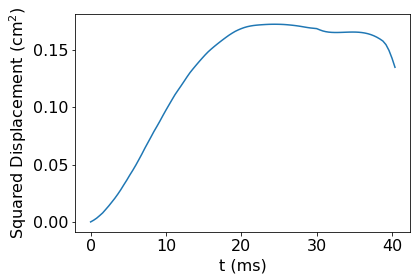

In [103]:
plt.plot(t_values,sd_values*DS**2)
format_plot(ax=plt.gca(),xlabel='t (ms)',ylabel=r'Squared Displacement (cm$^2$)',fontsize=16)

True

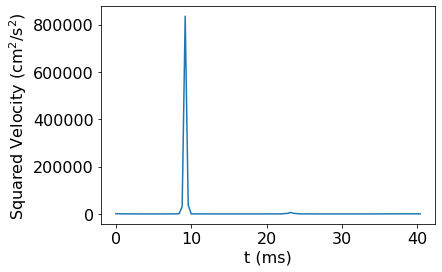

In [104]:
plt.plot(t_values,vsq_values)
format_plot(ax=plt.gca(),xlabel='t (ms)',ylabel=r'Squared Velocity (cm$^2$/s$^2$)',fontsize=16)

In [106]:
mean_lifetime=np.mean(lifetime_lst)

In [97]:
np.mean(v_rms_lst)

103.73975946970626

In [107]:
Delta_mean_lifetime=bootstrap_95CI_Delta_mean(x, num_samples=1000)

In [108]:
#TODO: fix v_rms
#TODO: aggregate over all annihilation events
#TODO: repeat for LR model

# TODO: measure period of oscillation 
- DONT: ~140ms and the parameters might be wrong - option A: for isolated spiral waves
- TODO: option B: for crowded spiral waves
        - option B.A:
        - HINT: try computing autocorrelation function of MSD, as for MSR, above...).
        - prerequisite, for each spiral pair involved in an annihilation, if it doesn't jump for x seconds, compute the MSD up until its first jump.
            - HINT: I think I have a function that does ^this somehwere...
            - TODO: check lib for this sd measurement function that works immediately.  If it doesn't work, just dev it here!
        - option B.B:
            - compare with some average measure of the period period,
            
$$
\hat{T}(t)=\frac{2\pi ||\vec{r}'(t)||^2}{||\vec{r}'(t)\times\vec{r}''(t)||}
$$

where the velocity and acceleration of the observed trajectory $\vec{r}(t)$ is computed using a Savitzky-Golay filtration.

# TODO: estimate v_rms and mean_turning_period from kinematics
- TODO: estimate conduction velocity from propagating plane waves of either full model
- TODO: record ^these values in THE TABLE